# Identifying "reasonable" parameter space for Pf-tent
In this work, I want to figure out my power to identify loci at which I can build immunity, depending on number of antigens, weight of antigens, number of loci, etc. However, I'm not sure what range of these variables even results in a reasonable model, so I'm going to explore parameter space to identify model "reasonableness".

As the outcome for reasonableness, I'll be using the following calculated per person:
- mean parasite density
- mean infection length
- mean moi
- % parasite density
- malaria cases per year
- time between first asymptomatic & last symptomatic
- average parasite density between first asymptomatic & last symptomatic
- age at first asymptomatic
- age at last asymptomatic

I will vary:
- half life
- xh
- b
- duration
- meroz
- timeToPeak
- maxParasitemia
- pgone
- immune thresh
- nAlleles
- nCtrlAlleles
- Power
- EIR


In [1]:
import pfTent as tent
import plotting as tp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time

In [2]:
def get_peaks(pdensity):
    '''
    Finds the time of all parasite density peaks
    '''
    lag = np.pad(pdensity,1,mode='constant')[:-2]
    sign = np.sign(pdensity-lag).astype(int)
    lead = np.pad(sign,(0,1), mode='constant')[1:]
    peak = np.where(sign > lead)[0]
    return peak

def get_asymptomatics(peaks, malaria):
    '''
    Returns peaks for asymptomatic cases
    '''
    asymps = []
    for peak in peaks:
        if peak not in malaria:
            asymps.append(peak)
    return asymps

def get_spacing(asymps, malaria):
    '''
    Returns time window between first asymptomatic case & last symptomatic case
    '''
    diff = malaria[-1] - asymps[0]
    return diff

def get_intermediate_density(peaks, asymps, malaria, pdensity):
    '''
    Returns mean peak parasite density between first asymptomatic & last symptomatic
    '''
    window = [peak for peak in peaks if peak >= asymps[0] and peak <= malaria[-1]]
    pdensities = [pdensity[time] for time in window]
    mean = np.average(pdensities)
    return mean

def create_weight_alleles(loci, alleles):
    '''
    Returns weight & allele vectors.
    '''
    starter = np.ones(loci)
    zero = np.zeros(1)
    a = alleles * np.append(np.ones(1), starter)
    a = a.astype(int)
    strain = starter * (1/loci)
    w = np.append(np.zeros(2), strain)
    return a, w

In [3]:
y=5 # Simulate for 5 years
a = [5,5,5,5] # control,antigenic loci 1, antigenic loci 2, antigenic loci 3
w = [0,0.333333,0.3333333,0.333333] # general immunity, control, antigenic loci 1, antigenic loci 2, antigenic loci 3
n_people = 100
fever, breaks = tent.load_data()
eir=40
fever_arr = tent.get_fever_arr(eir,fever,breaks)

In [10]:
pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr)

In [11]:
pdensity = pmatrix[0,:,:].sum(axis=0)

In [12]:
peaks = get_peaks(pdensity)

In [13]:
asymps = get_asymptomatics(peaks,malaria)

In [14]:
get_spacing(asymps, malaria)

42

In [15]:
get_intermediate_density(peaks,asymps,malaria,pdensity)

4634.638304288288

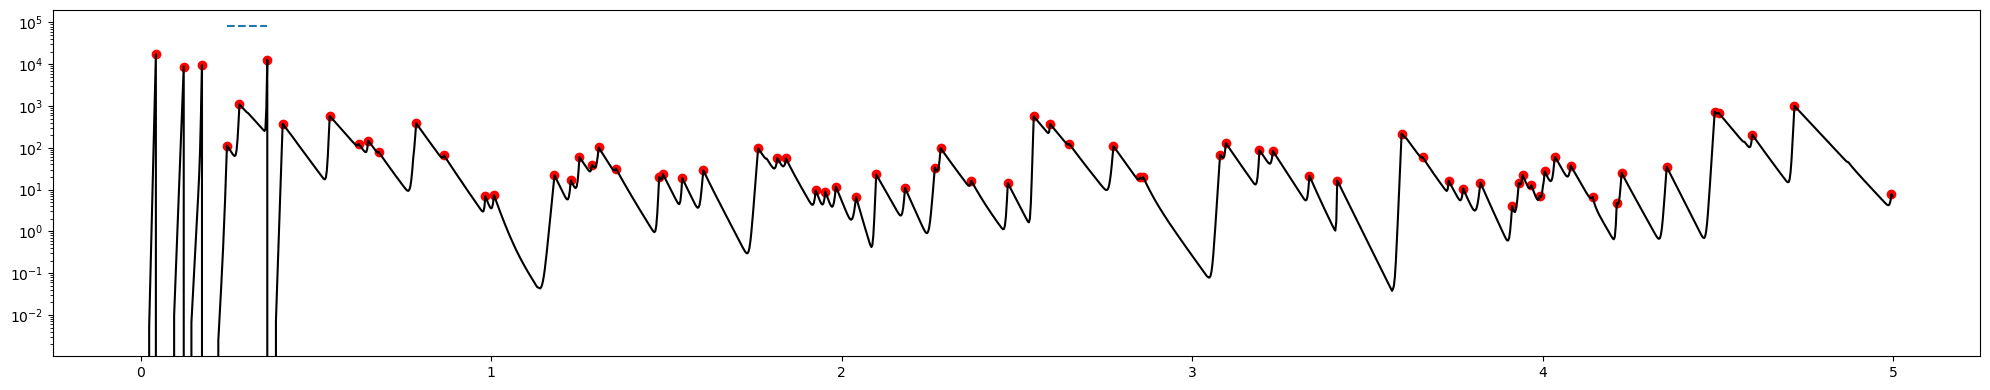

In [16]:
peak_values = []
for time in peaks:
    peak_values.append(pdensity[time])
    
window = [asymps[0]/365, malaria[-1]/365]

fig, ax = plt.subplots(tight_layout=True, figsize=(20,4))
ax.plot(np.arange(y*365)/365, pdensity,color="black")
ax.scatter(peaks/365, peak_values, color='red')
ax.set_yscale('log')
ax.plot(window,[83637,83637], linestyle='dashed')


(0.75, 1.5)

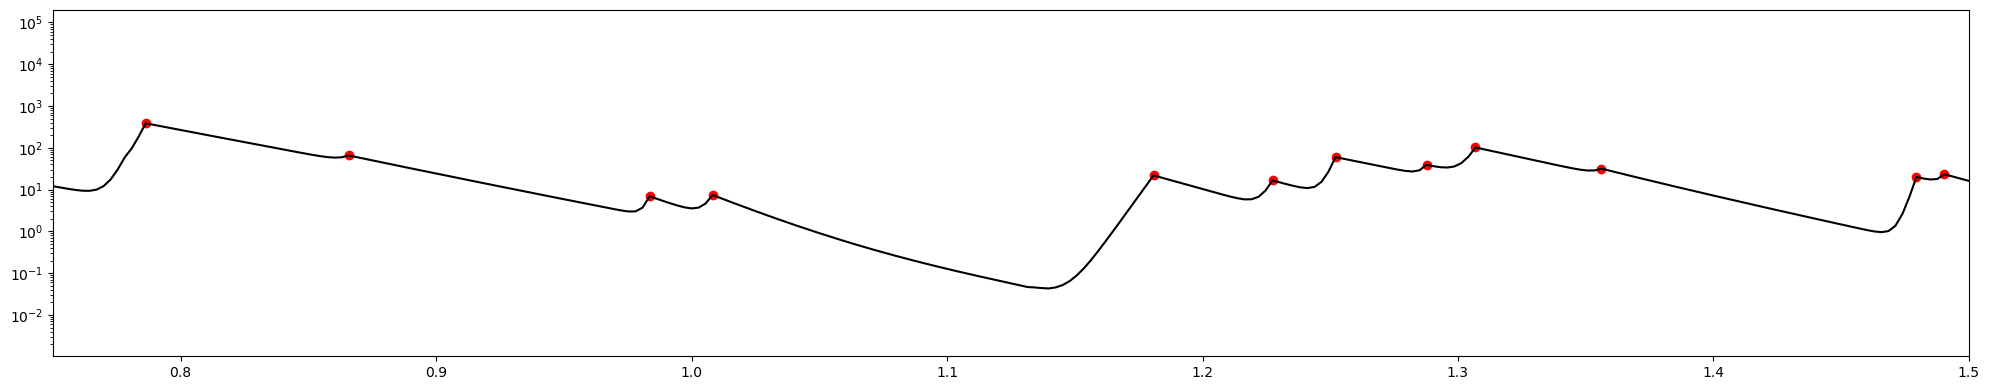

In [17]:
fig, ax = plt.subplots(tight_layout=True, figsize=(20,4))
ax.plot(np.arange(y*365)/365, pdensity,color="black")
ax.scatter(peaks/365, peak_values, color='red')
ax.set_yscale('log')
ax.plot(window,[83637,83637], linestyle='dashed')
ax.set_xlim([0.75,1.5])

Peak only looks weird because treatment threshold is daily calculated, so it gets treated because above threshold that day. Really should redefine treatment.

But peaks are in the right spot!! Woohoo!!

Average peak density is a little weird because pdensity is best interepret on the log scale. Consider revisiting this.

But for now, let's try this applied to a bunch of values.


In [4]:
y = 5
n_people = 100
outcomeLabels = ["Median parasite density",
                 "Mean parasite density",
                 "Median infection length",
                 "Mean infection length",
                 "Median MOI",
                 "Mean MOI",
                 "Percent with parasitemia",
                 "Malaria cases",
                 "Day of first asymptomatic",
                 "Day of last malaria",
                 "Days between first asymptomatic & last malaria",
                 "Average parasite density peaks between first asymptomatic & last malaria"
                ]
outputs = ["../figs/medPdens_","../figs/avgPdens_","../figs/medlength_","../figs/avglength_","../figs/medMOI_","../figs/avgMOI_","../figs/prev_","../figs/malaria_","../figs/firstDay_","../figs/lastDay_","../figs/asymps_","../figs/asympDays_"]
a = [10,10,10,10,10]
w = [0.2,0.2,0.2,0.2,0.2]
outcomeLog = [True, True, False, False, False, False, False, False, False, False, False, True]

In [5]:
lowess = sm.nonparametric.lowess

def plot(arr, ylab, logy, intervals,n_people,xlab,output,variable,logx=False):
    '''
    Plots results of banding
    '''
    x = np.repeat(intervals,n_people)
    flattened = arr[:,:].flatten('F')
    smoothed = lowess(flattened, x, return_sorted=False, frac=0.25)

    fig, ax = plt.subplots(tight_layout=True, figsize=(6,4))
    ax.scatter(x, flattened, alpha=0.3, color='blue')
    ax.plot(x, smoothed, color='black')
    if logy == True:
        ax.set_yscale('log')
    if logx == True:
        ax.set_xscale('log')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.savefig(output+variable+".pdf")

## Immune decay half-life

In [25]:
halflives = [25,50,75,100,150,200,300,400,500,600,700,800,900,1000]

In [37]:
outcomes = np.empty((len(outcomeLabels),n_people,len(halflives)))

for i,hl in enumerate(halflives):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,t12=hl)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        outcomes[8,person,i] = asymps[0]
        outcomes[9,person,i] = malaria[-1]
        outcomes[10,person,i] = get_spacing(asymps, malaria)
        outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
    end = time.time()
    print(end-start)

4.949621915817261
4.774965047836304
4.615938901901245
4.553972005844116
4.449413061141968
4.42464280128479
4.26583194732666
4.17511510848999
4.076148986816406
4.015152931213379
3.913465976715088
3.850501775741577
3.8140528202056885
3.7593889236450195


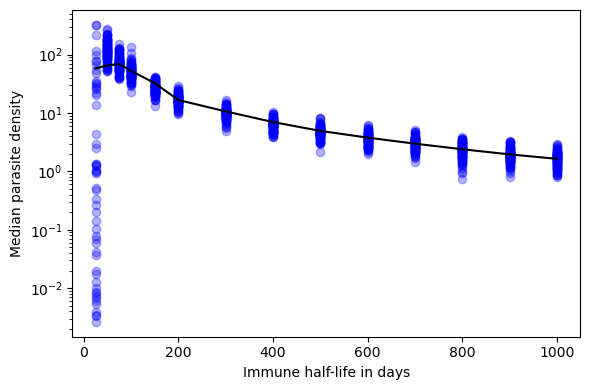

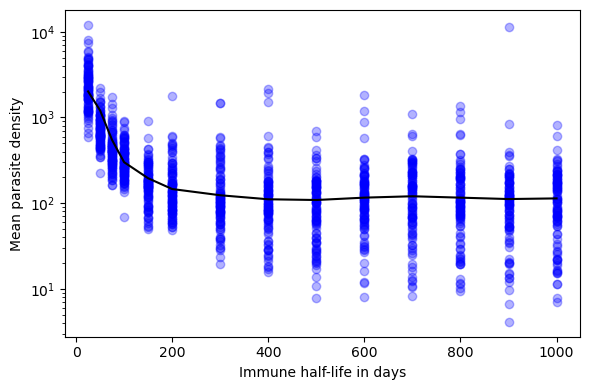

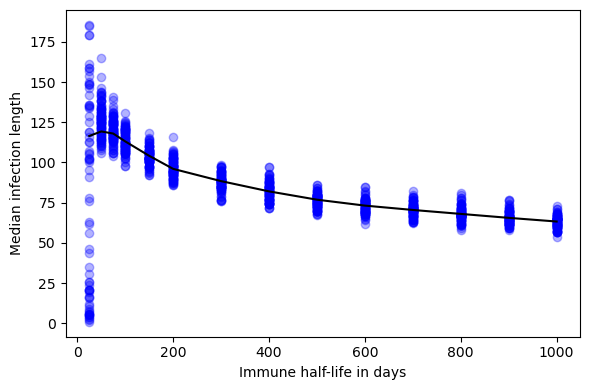

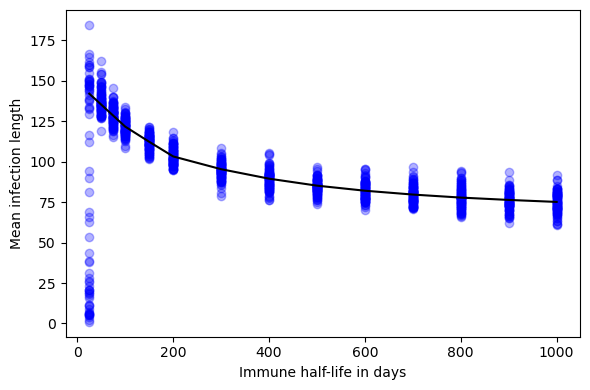

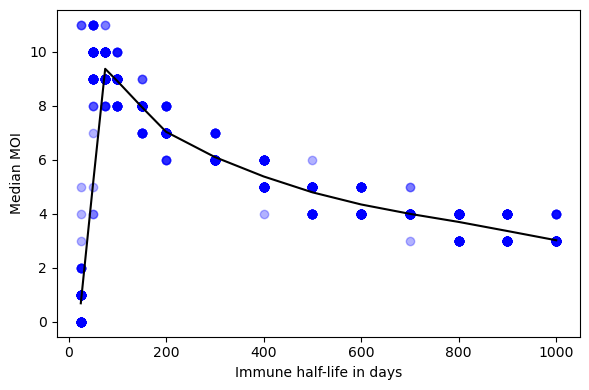

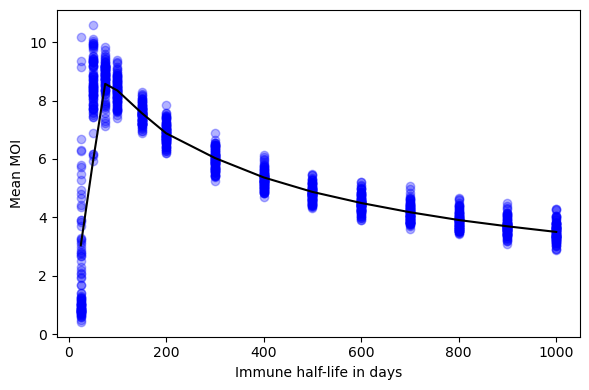

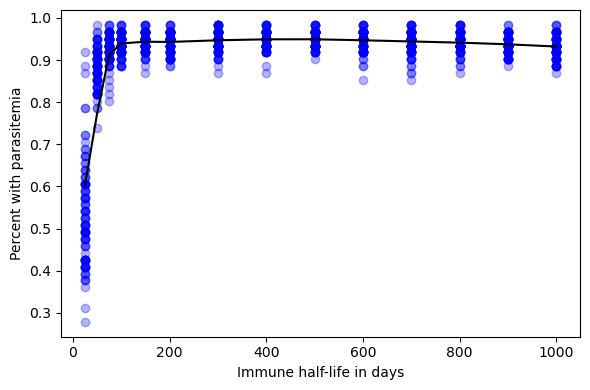

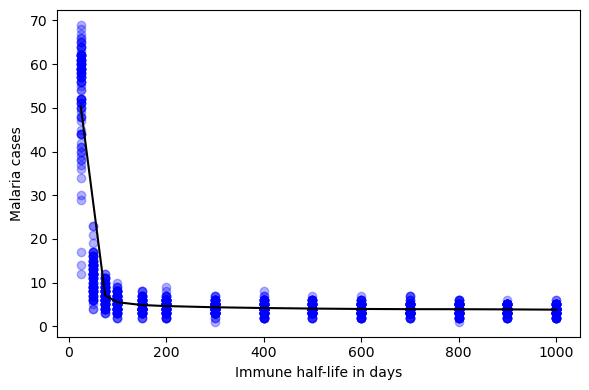

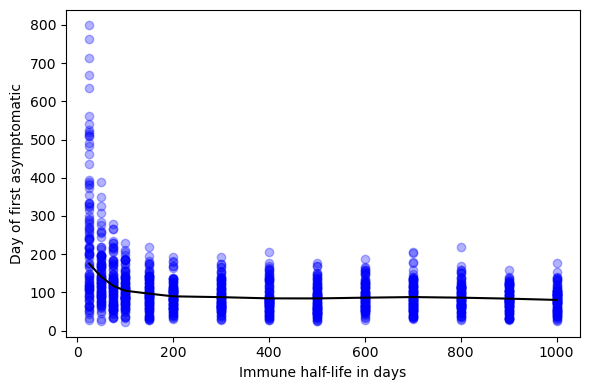

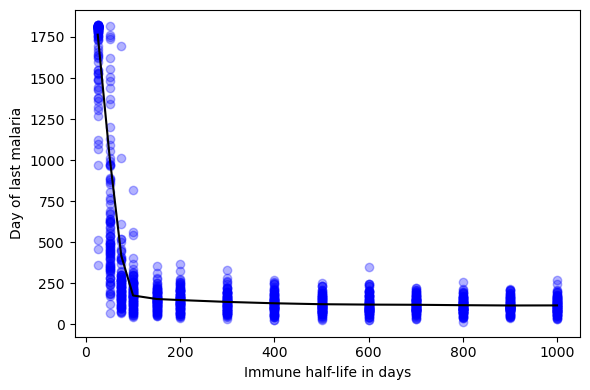

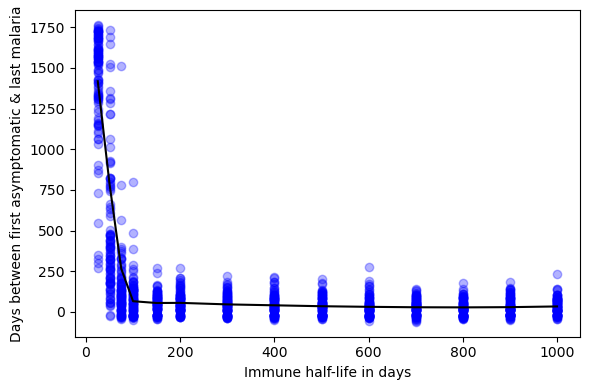

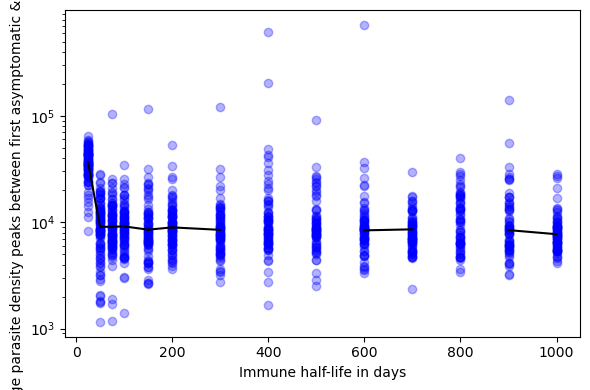

In [61]:
outputs = ["../figs/medPdens_","../figs/avgPdens_","../figs/medlength_","../figs/avglength_","../figs/medMOI_","../figs/avgMOI_","../figs/prev_","../figs/malaria_","../figs/firstDay_","../figs/lastDay_","../figs/asymps_","../figs/asympDays_"]
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, halflives,n_people,"Immune half-life in days",output,"t12")


## xH

In [6]:
values = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]

In [7]:
outcomes = np.empty((len(outcomeLabels),n_people,len(values)))

for i,xh in enumerate(values):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,xh=xh)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3.158616781234741
3.932543992996216
4.1957948207855225
4.319137096405029
4.432759046554565
4.486270189285278
4.536163806915283
4.625771999359131
4.773170232772827


/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


4.82125186920166
4.661958932876587


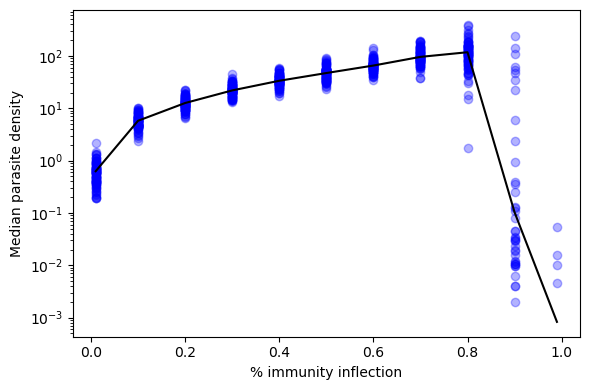

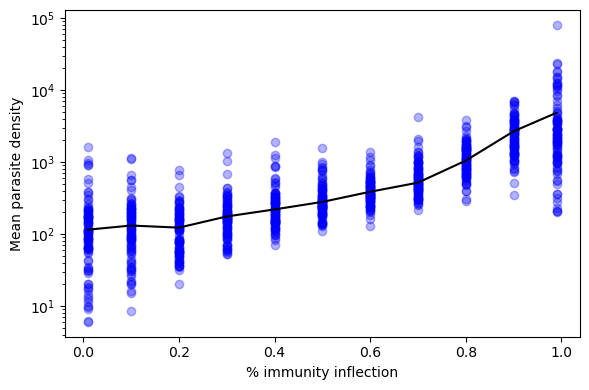

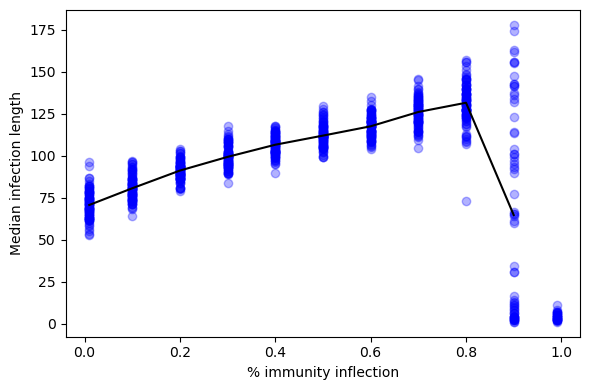

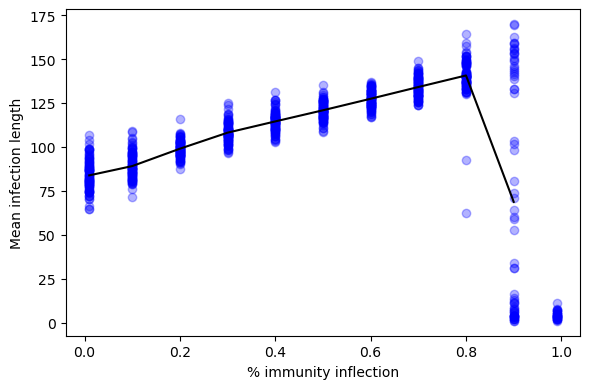

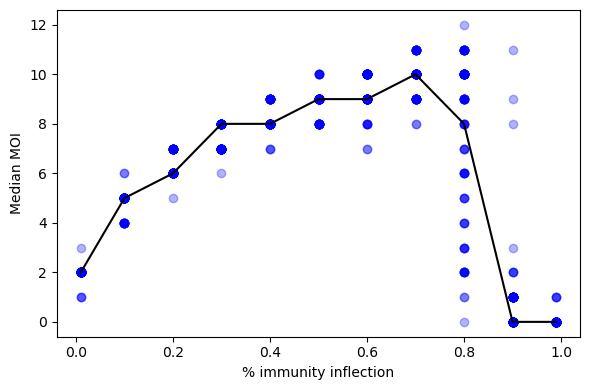

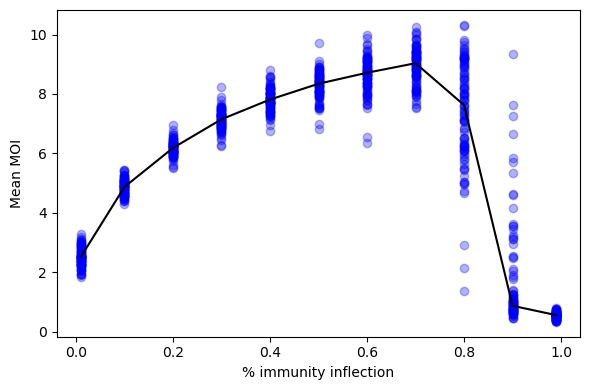

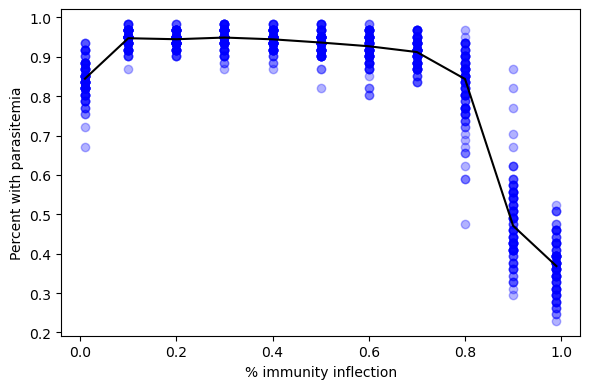

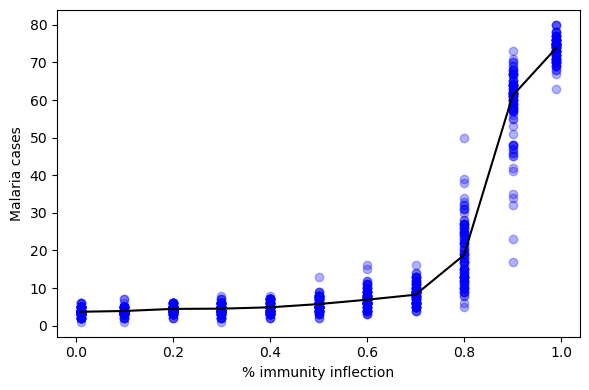

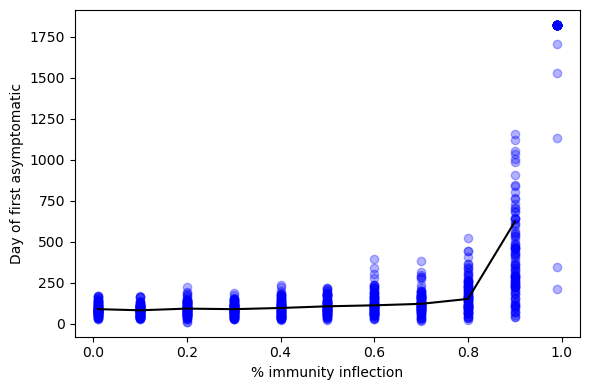

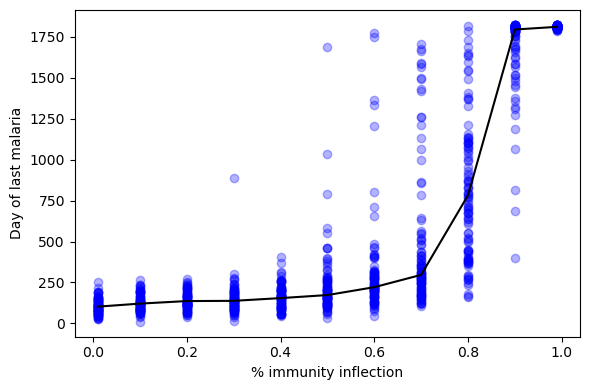

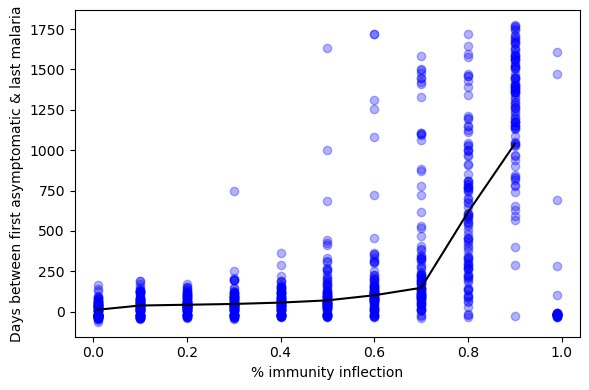

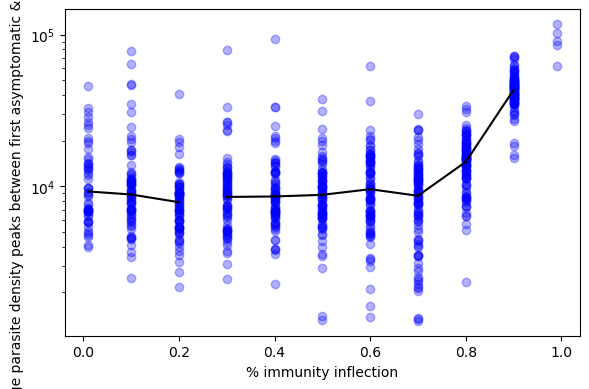

In [8]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, values,n_people,"% immunity inflection",output,"xh")

## b

In [72]:
bs = [-0.1,-0.25,-0.5,-0.75,-1,-2,-3,-4,-5]

In [73]:
outcomes = np.empty((len(outcomeLabels),n_people,len(bs)))

for i,b in enumerate(bs):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,b=b)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.9276251792907715
4.8090150356292725
4.740242958068848
4.700700044631958
4.599460124969482
4.5010340213775635
4.498945713043213
4.445968866348267
4.488645792007446


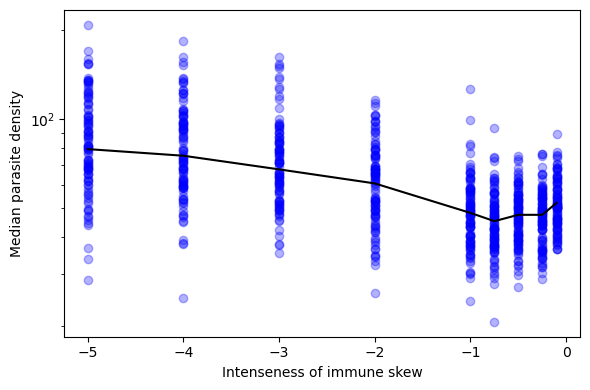

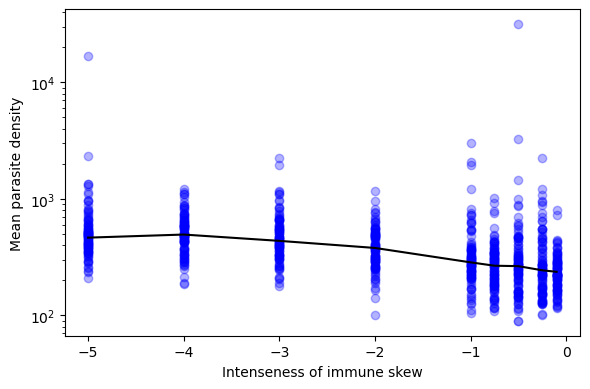

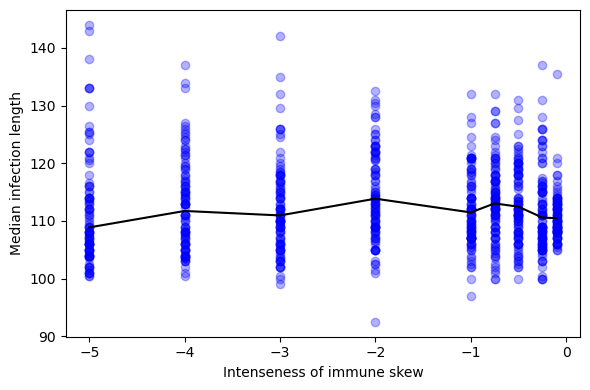

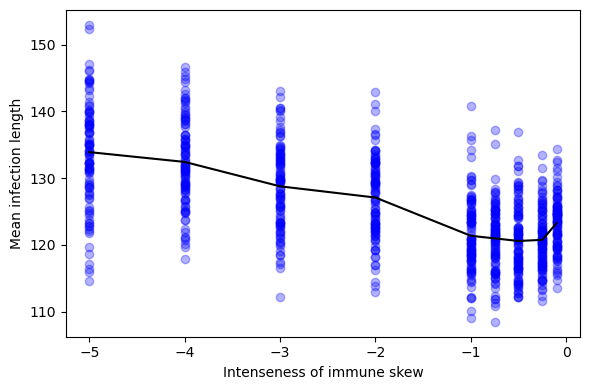

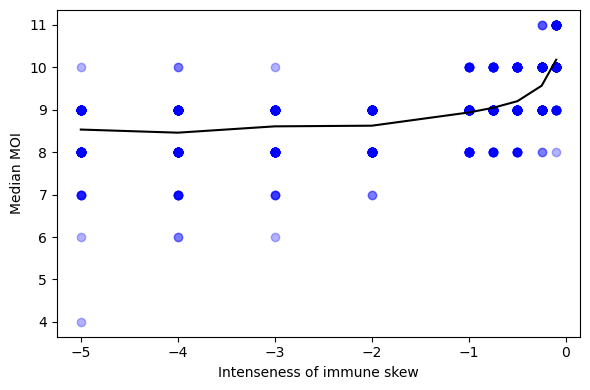

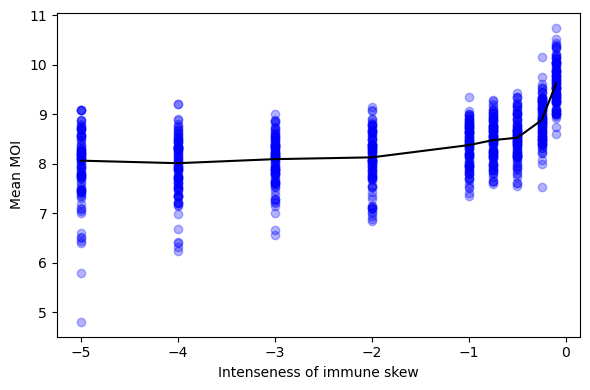

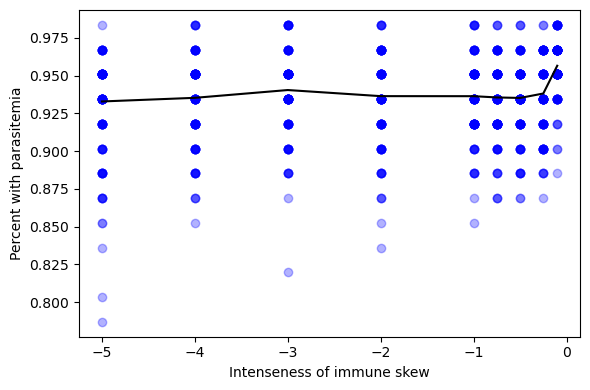

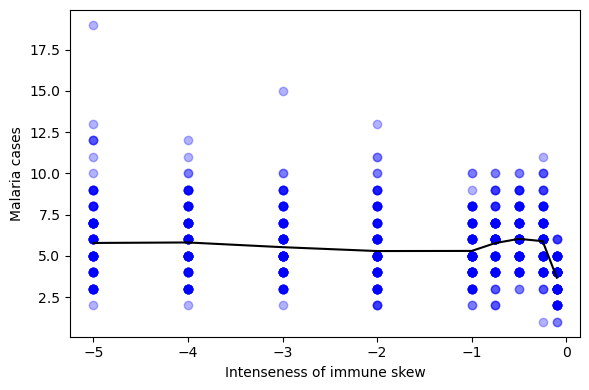

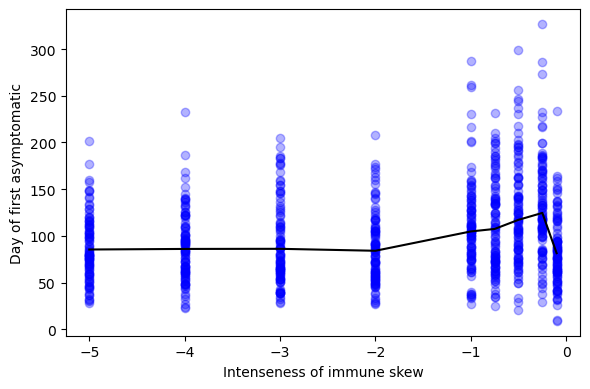

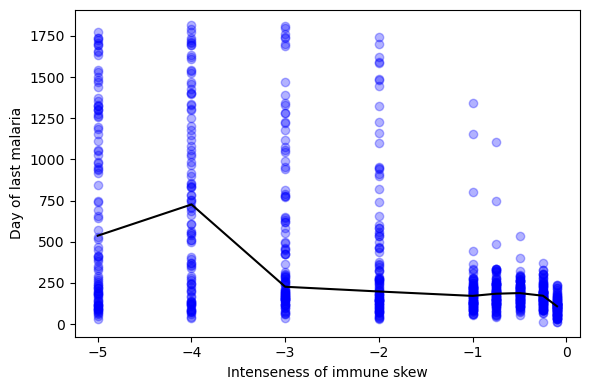

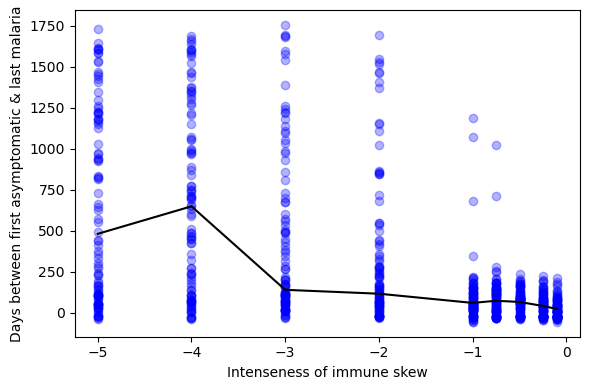

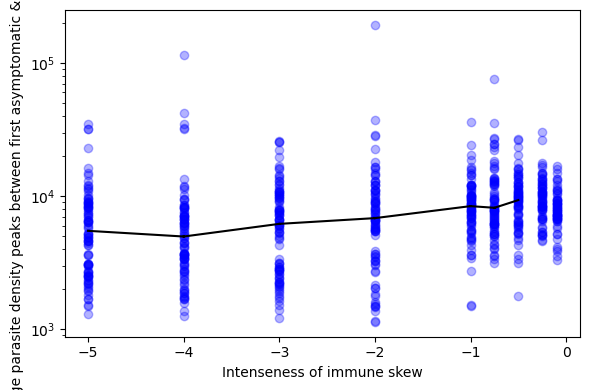

In [75]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, bs,n_people,"Intenseness of immune skew",output,"b")

## Duration

In [76]:
durs = [1000,900,800,700,600,500,400,300,200,100]

In [77]:
outcomes = np.empty((len(outcomeLabels),n_people,len(durs)))

for i,dur in enumerate(durs):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,duration=dur)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.204692840576172
4.256765842437744
4.347872018814087
4.436426639556885
4.626394987106323
4.693758964538574
4.779828071594238
4.930176019668579
5.0541160106658936
5.163625001907349


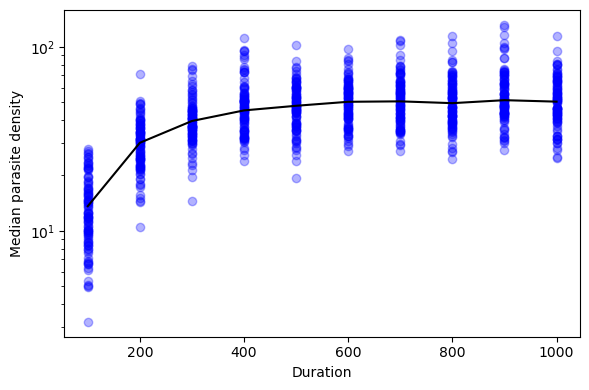

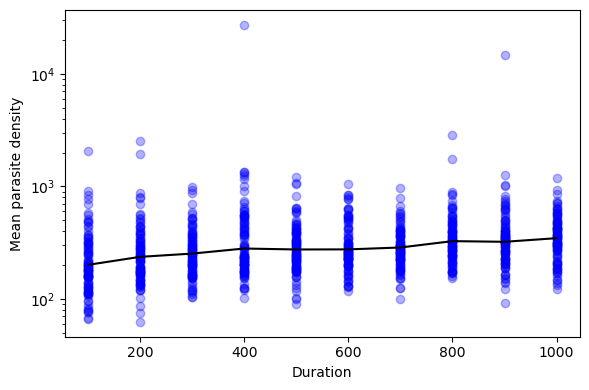

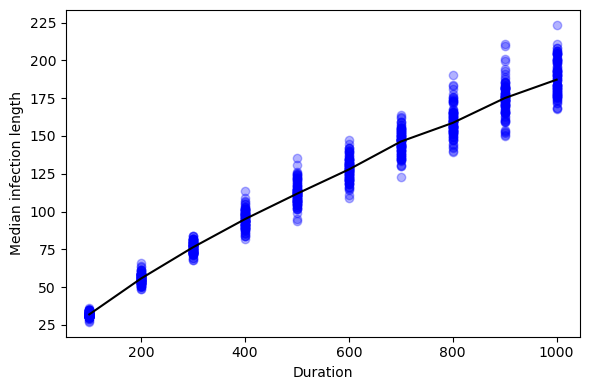

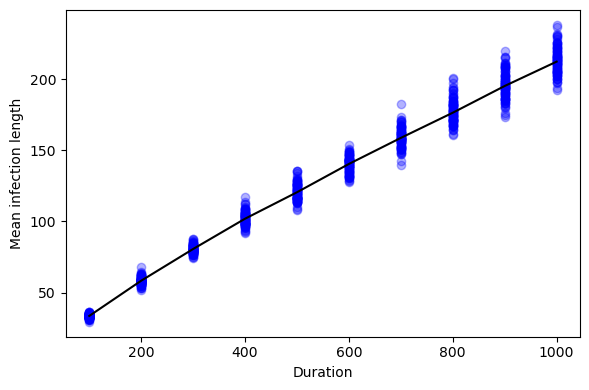

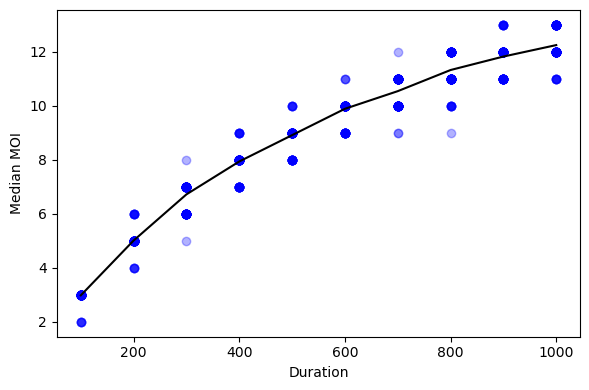

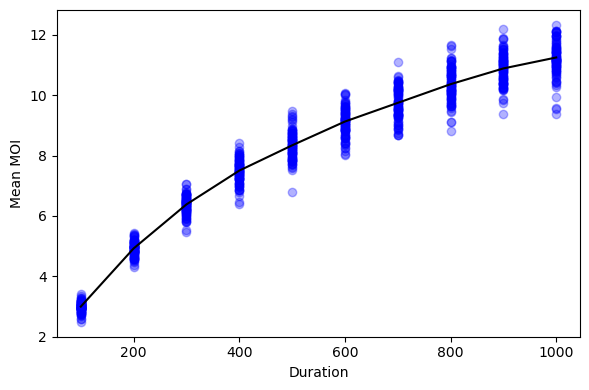

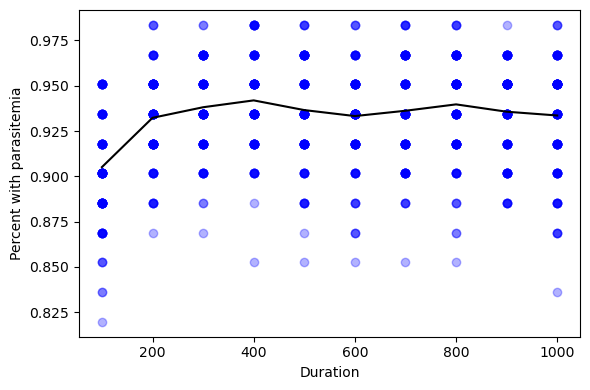

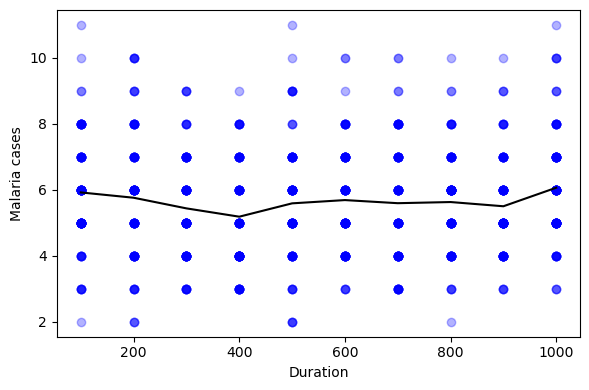

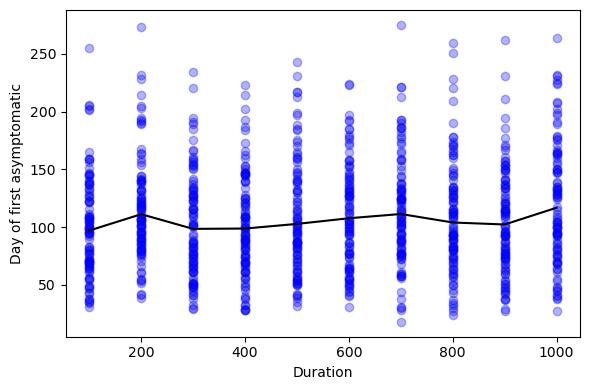

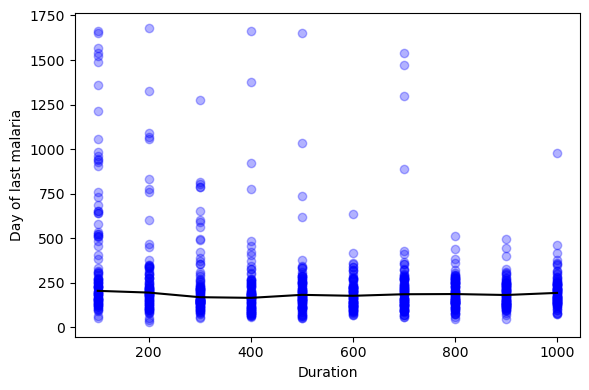

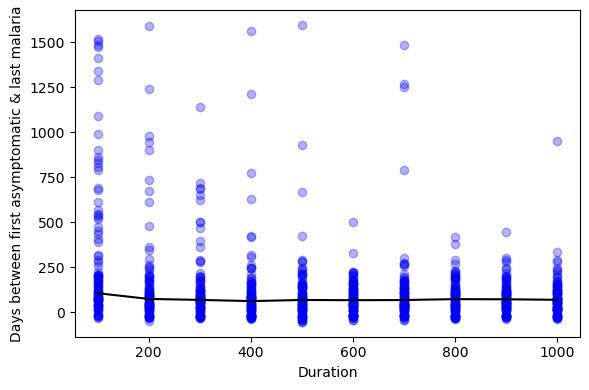

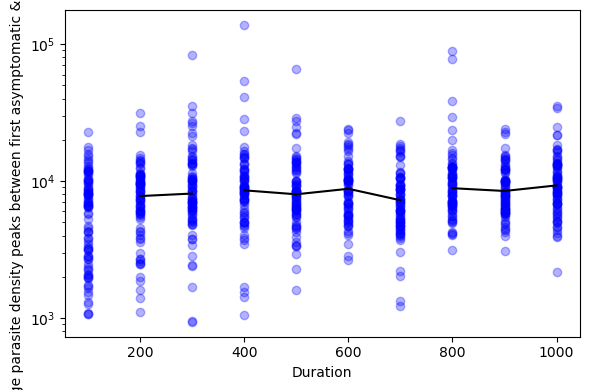

In [78]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, durs,n_people,"Duration",output,"dur")

## Merozoites

In [79]:
merozs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

In [80]:
outcomes = np.empty((len(outcomeLabels),n_people,len(merozs)))

for i,mz in enumerate(merozs):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,meroz=mz)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3.045922040939331


/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


4.056462049484253
4.655097961425781
5.268040895462036
5.269700050354004
5.268410921096802
5.32221794128418


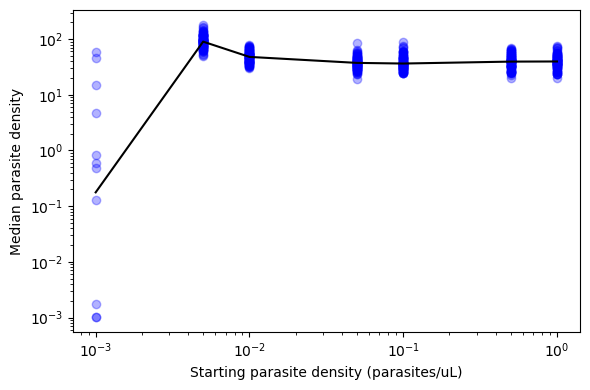

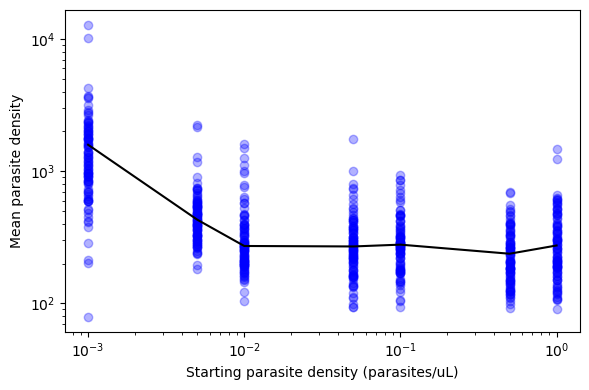

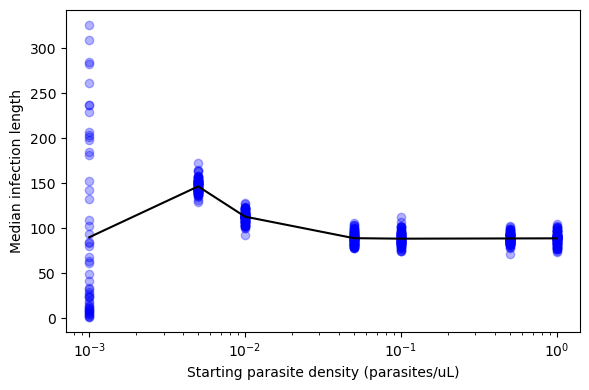

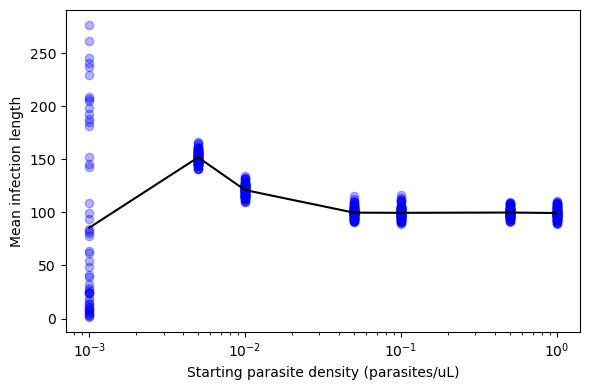

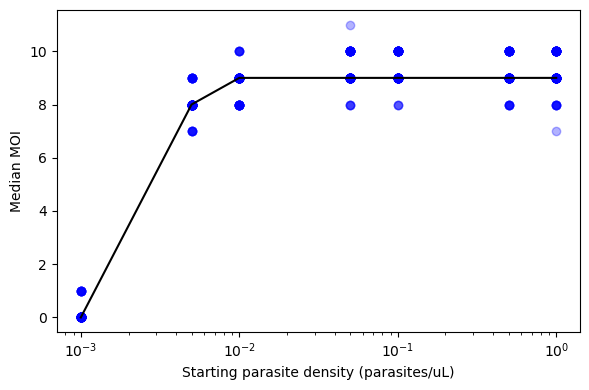

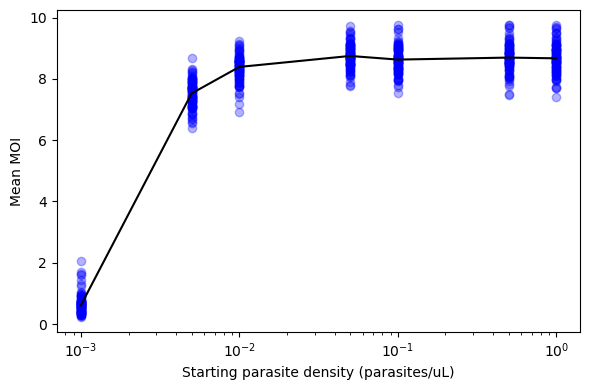

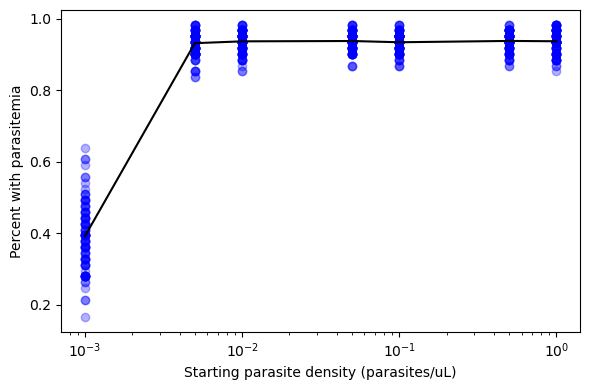

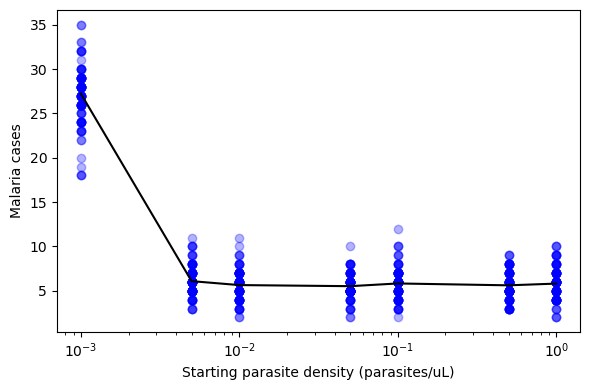

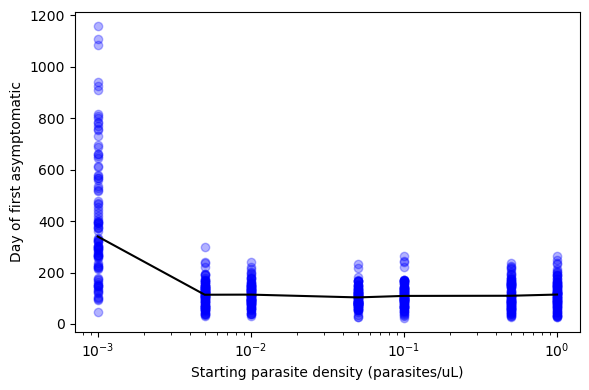

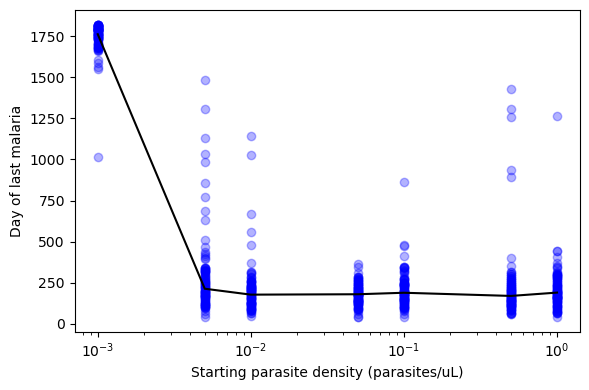

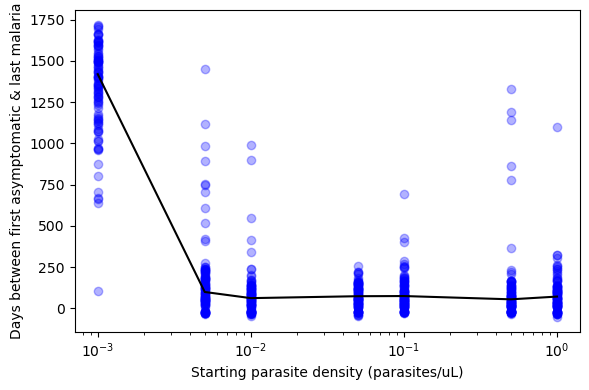

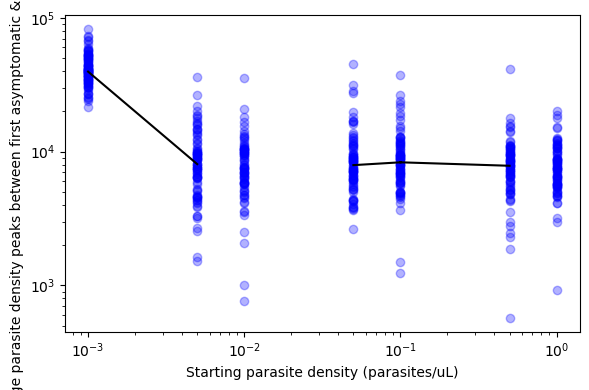

In [85]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, merozs,n_people,"Starting parasite density (parasites/uL)",output,"mz0",logx=True)

## Time of Peak

In [86]:
peaktimes = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [87]:
outcomes = np.empty((len(outcomeLabels),n_people,len(peaktimes)))

for i,pt in enumerate(peaktimes):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,timeToPeak=pt)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.559652090072632
4.5609800815582275
4.637095928192139
4.616111993789673
4.650864839553833
4.650139093399048
4.683603286743164
4.648839950561523
4.634690046310425
4.672839879989624
4.643063068389893
4.660812139511108
4.622931003570557
4.549290895462036
4.660758018493652
4.621692180633545


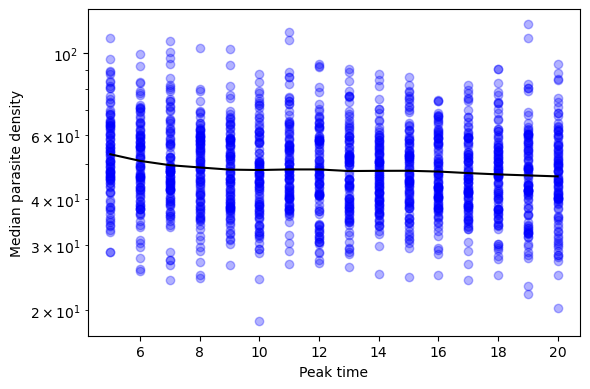

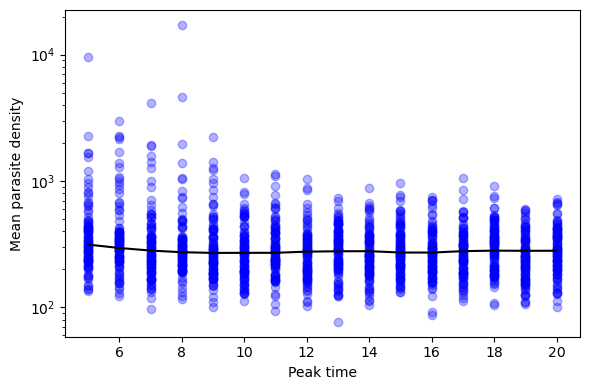

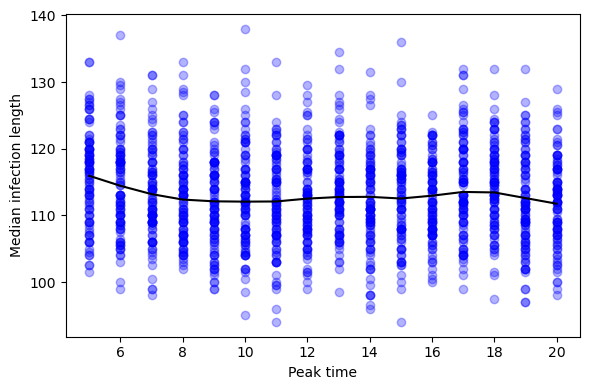

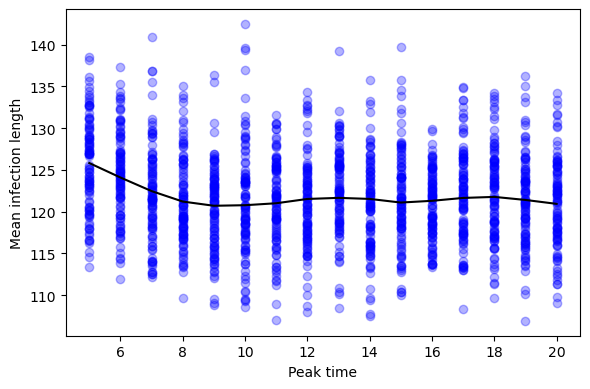

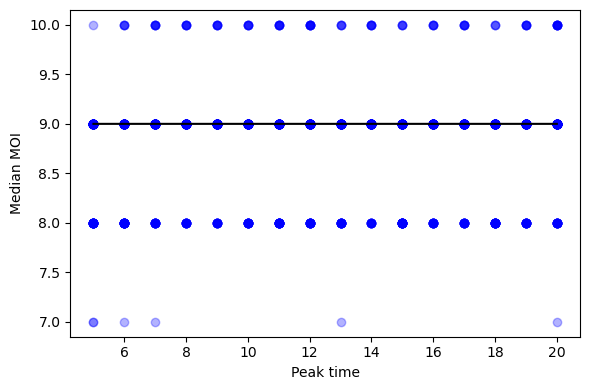

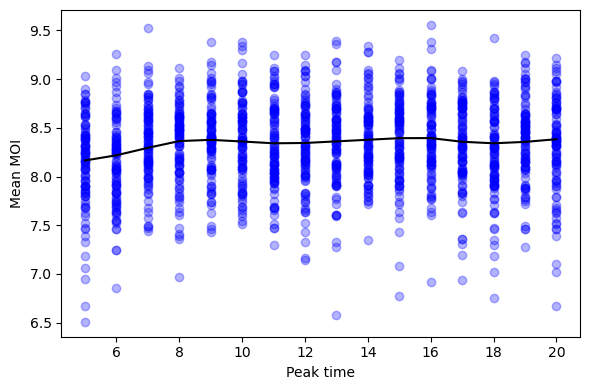

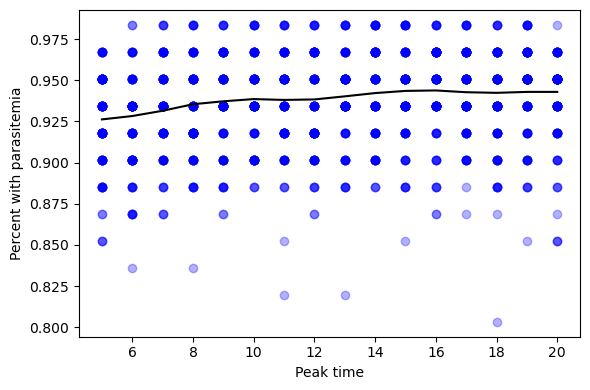

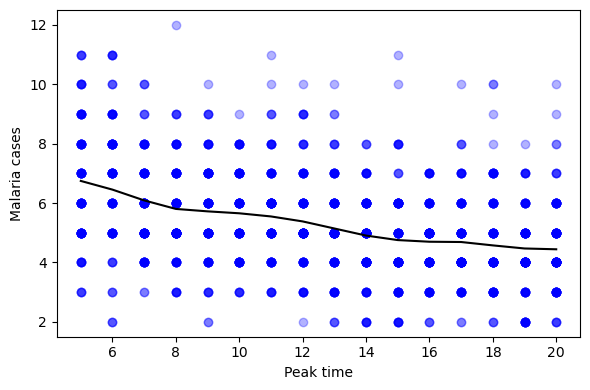

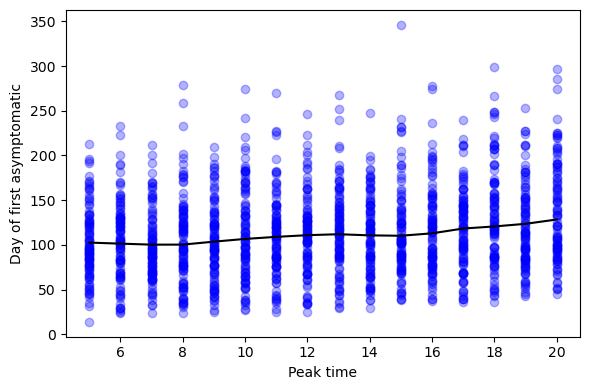

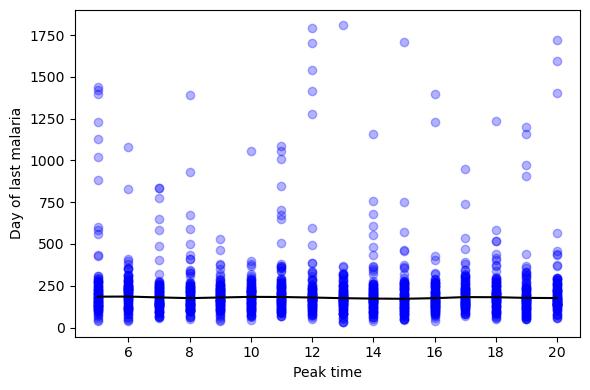

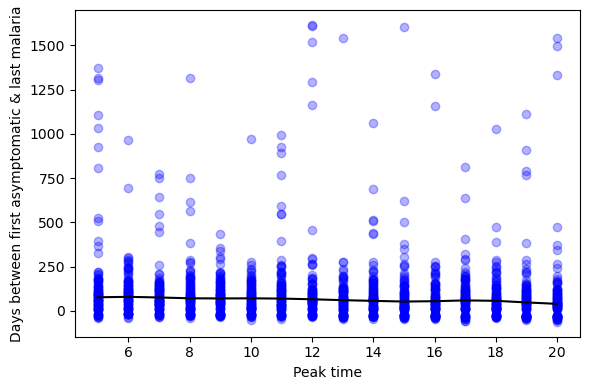

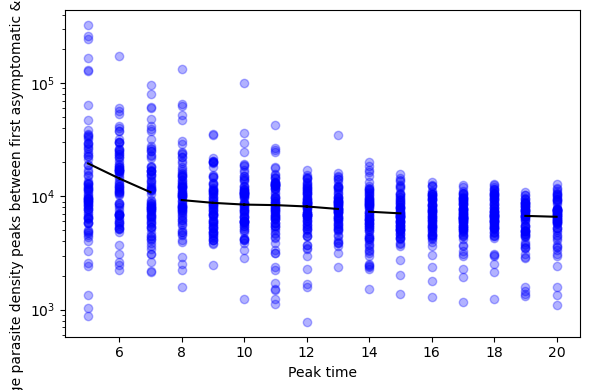

In [88]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, peaktimes,n_people,"Peak time",output,"peakTime")

## Max Parasitemia

In [89]:
maxPs = [4.6,4.8,5,5.2,5.4,5.6,5.8,6,6.2,6.4,6.6,6.8,7]

In [90]:
outcomes = np.empty((len(outcomeLabels),n_people,len(maxPs)))

for i,mP in enumerate(maxPs):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,maxParasitemia=mP)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.624078750610352
4.63377571105957
4.68619704246521
4.655962944030762
4.666625022888184
4.630001783370972
4.615018606185913
4.6594929695129395
4.684875965118408
4.739344835281372
4.761850118637085
4.698586940765381
4.717879056930542


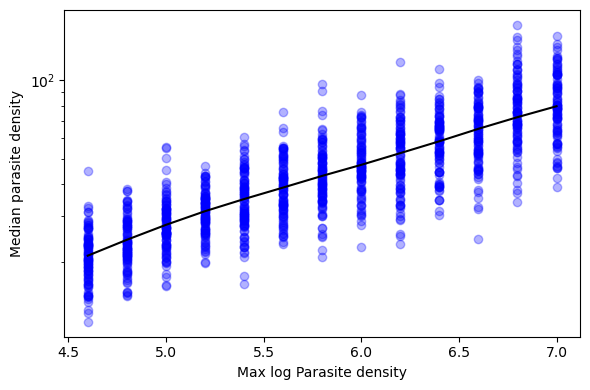

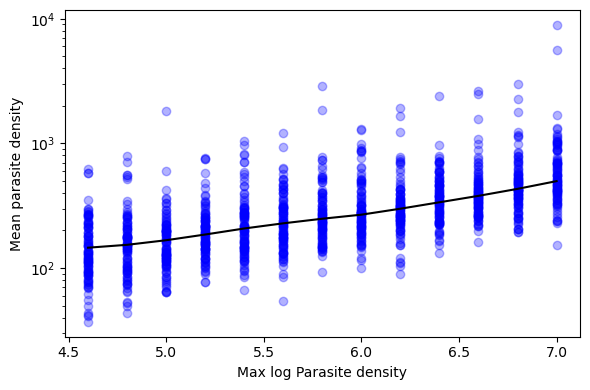

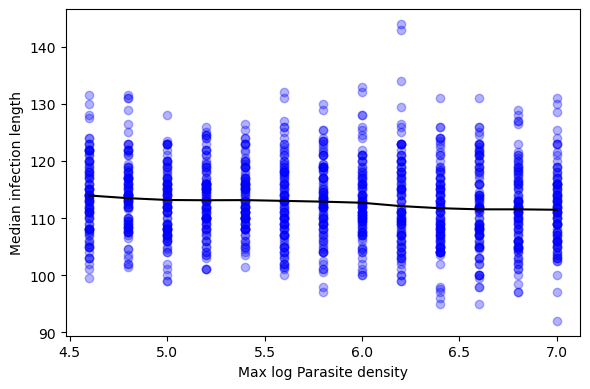

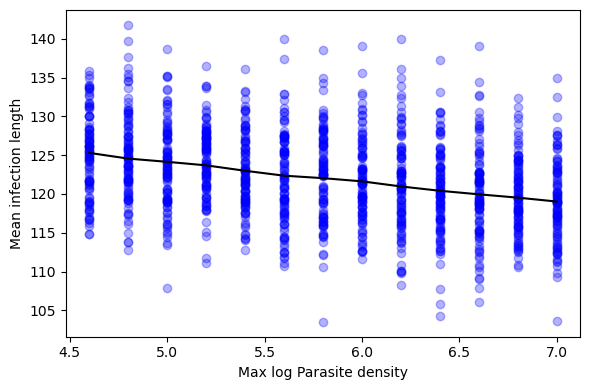

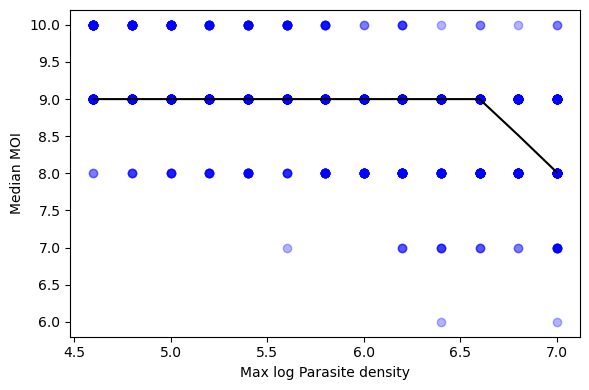

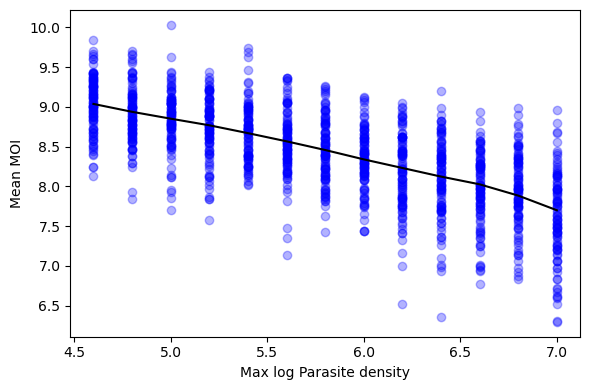

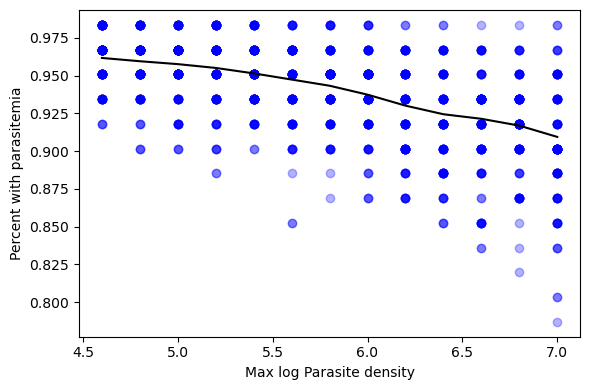

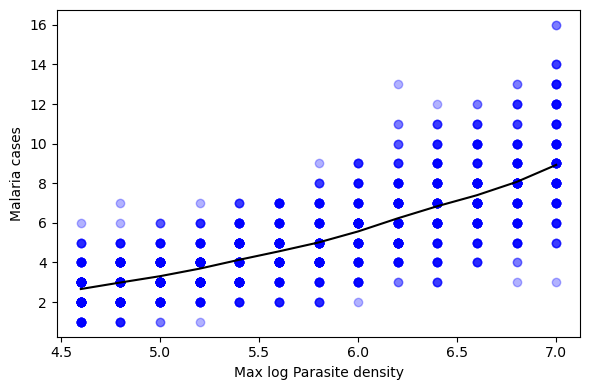

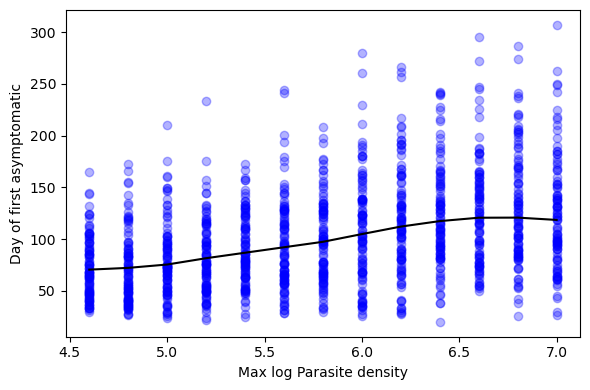

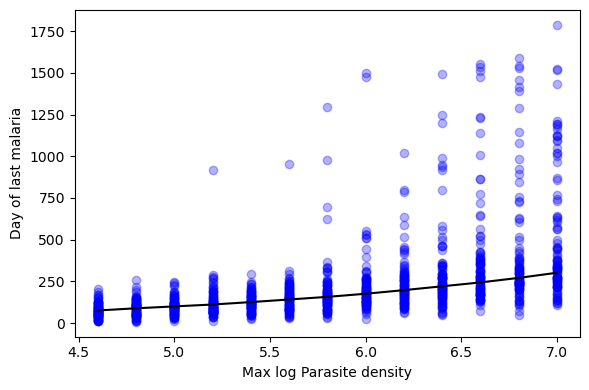

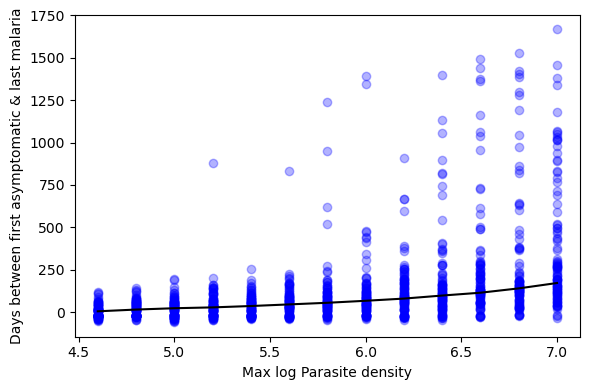

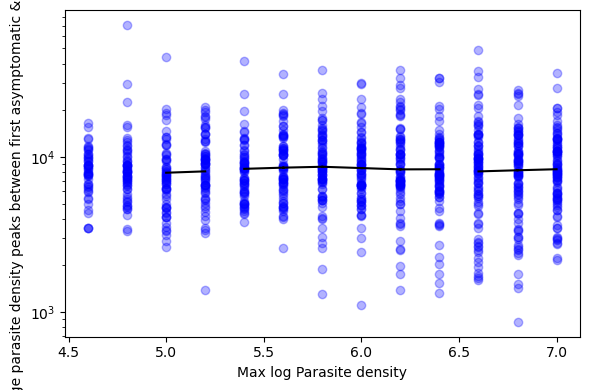

In [91]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, maxPs,n_people,"Max log Parasite density",output,"maxP")

## Parasite gone

In [92]:
pgones = [-5,-4.5,-4,-3.5,-3,-2.5,-2]

In [93]:
outcomes = np.empty((len(outcomeLabels),n_people,len(pgones)))

for i,pgone in enumerate(pgones):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,pgone=pgone)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.805755853652954
4.741613864898682
4.701657056808472
4.744287014007568
4.673529863357544
4.592986822128296
4.466832160949707


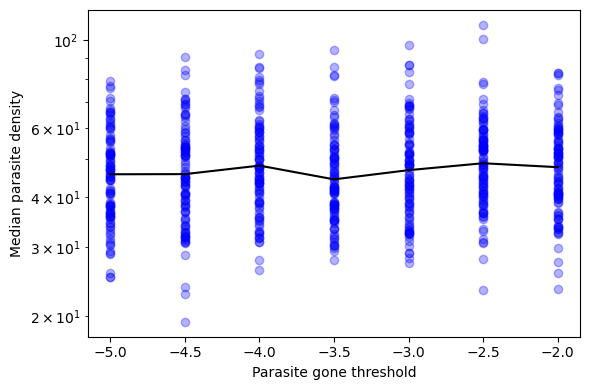

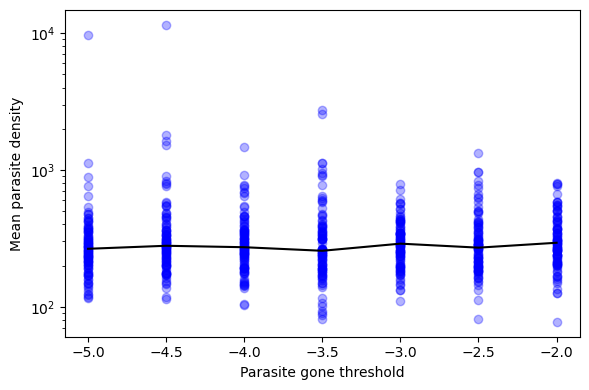

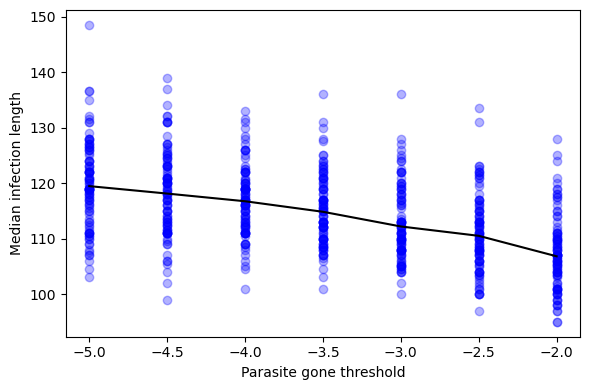

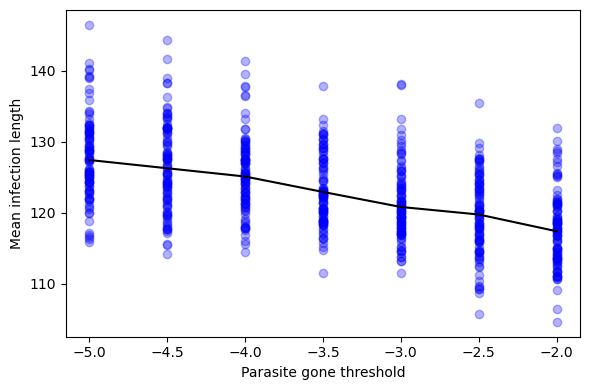

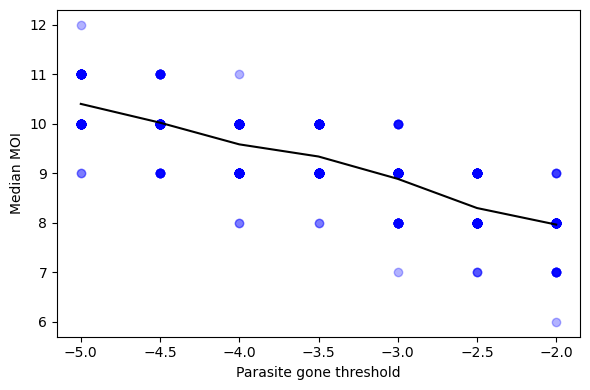

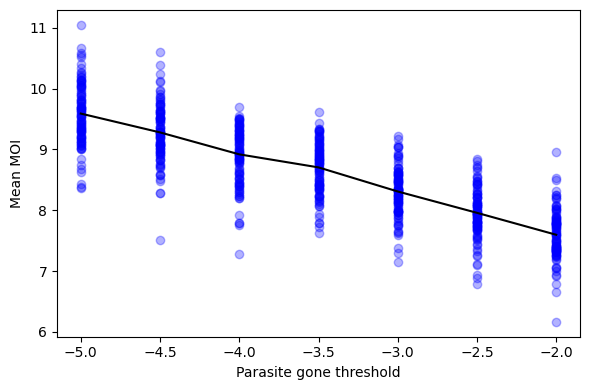

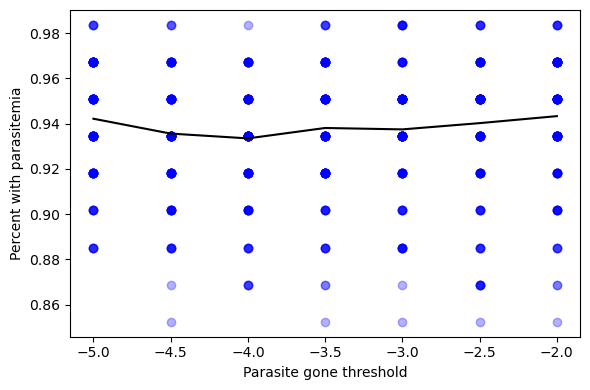

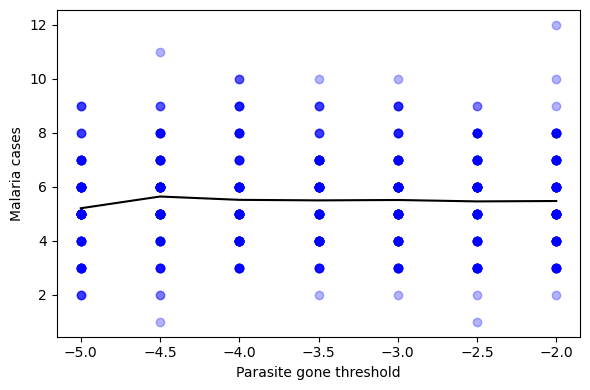

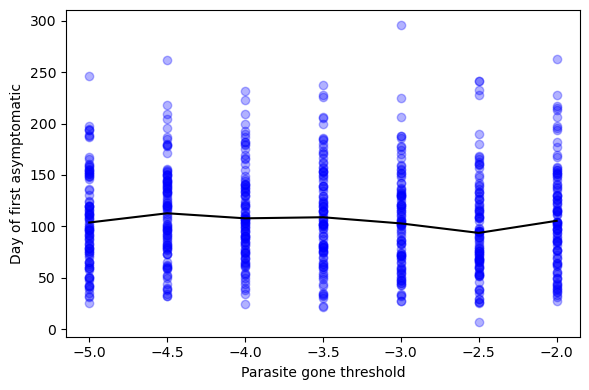

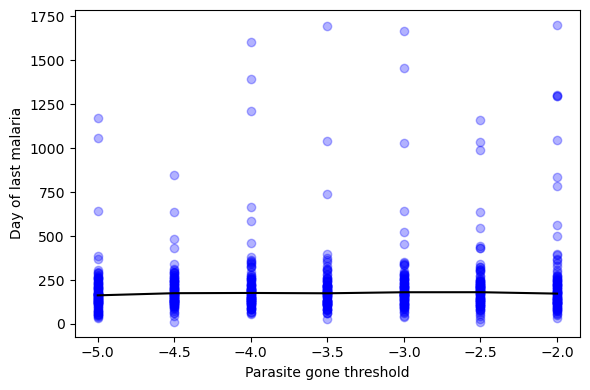

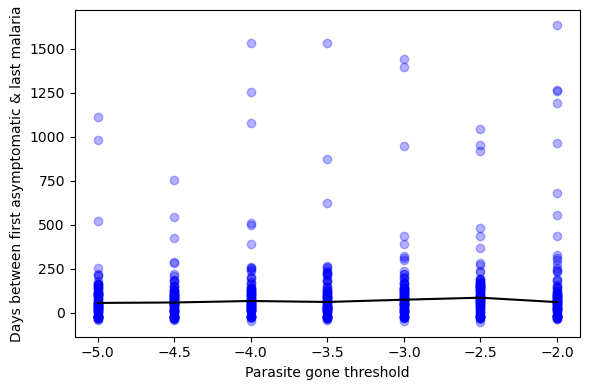

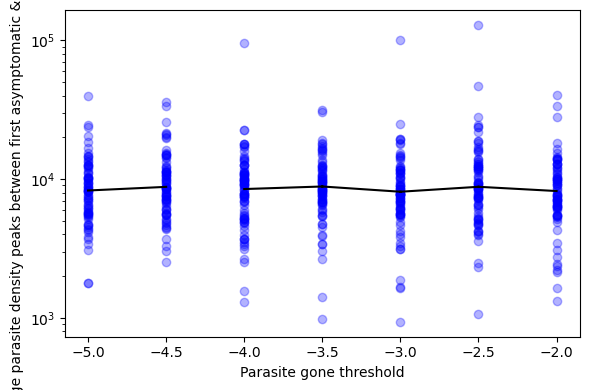

In [94]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, pgones,n_people,"Parasite gone threshold",output,"pgone")

## Immune Threshhold

In [95]:
immunes = [0.001,0.005,0.01,0.015,0.02,0.025,0.05,0.075,0.1]

In [96]:
outcomes = np.empty((len(outcomeLabels),n_people,len(immunes)))

for i,ithresh in enumerate(immunes):
    start = time.time()
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,immune_thresh=ithresh)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.414799928665161
4.5558247566223145
4.627822160720825
4.626052141189575
4.679002046585083
4.646943092346191
4.713965177536011
4.728255987167358
4.803603887557983


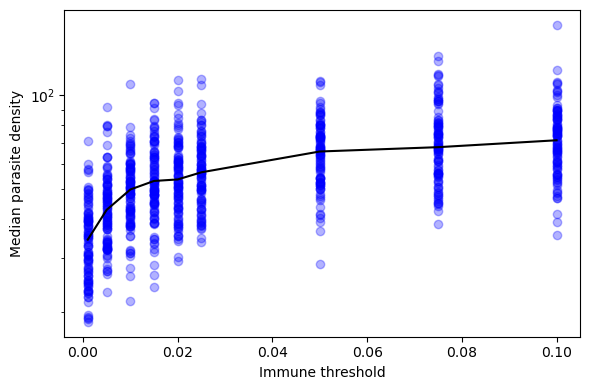

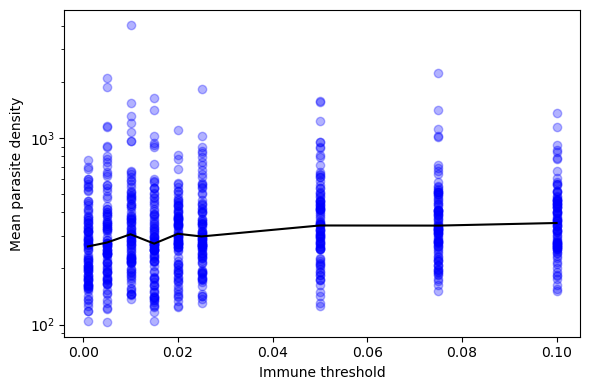

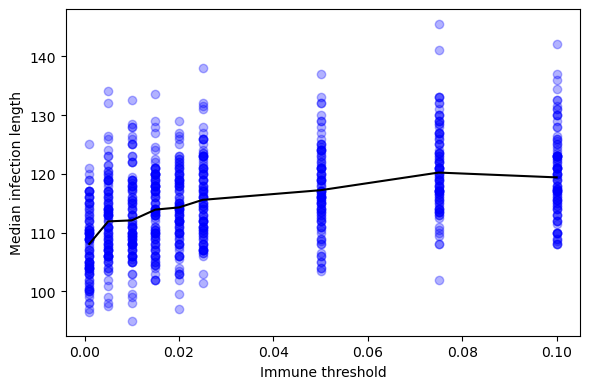

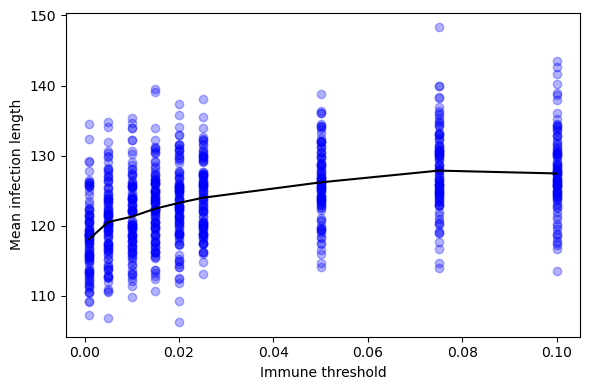

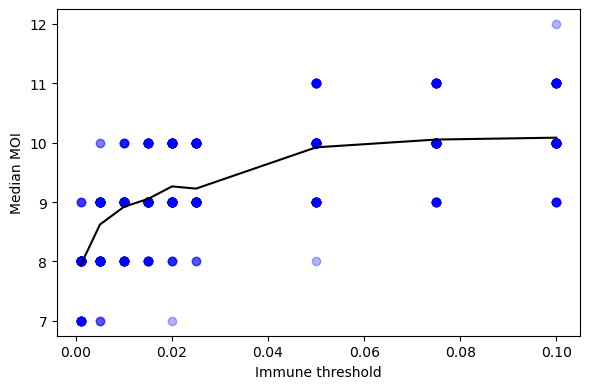

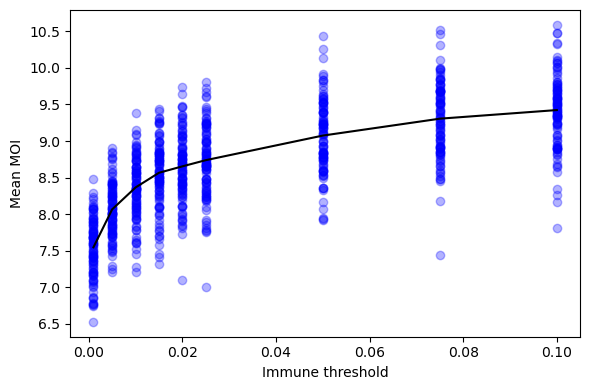

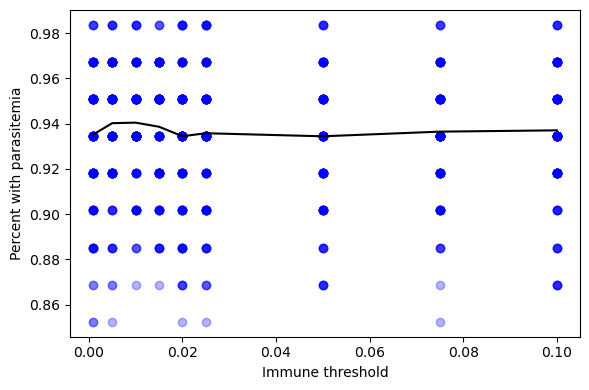

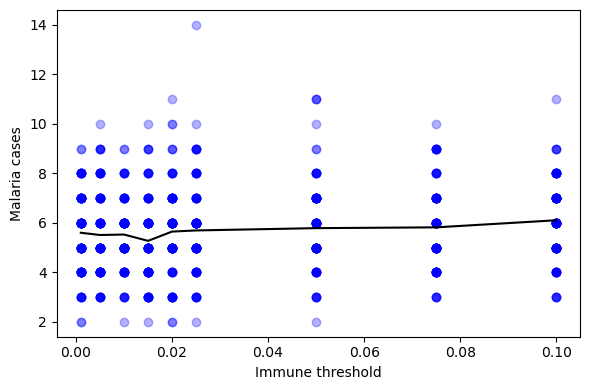

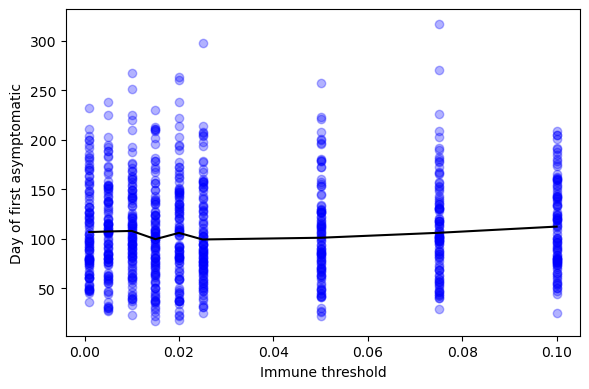

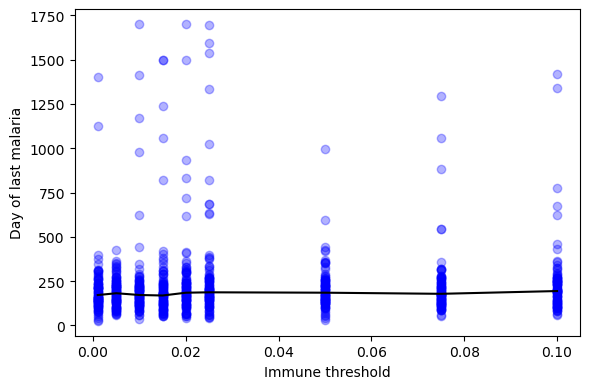

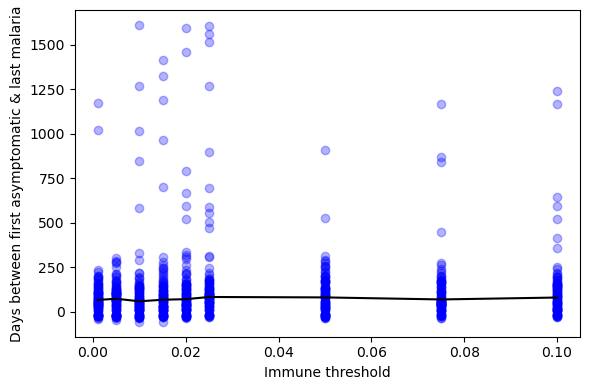

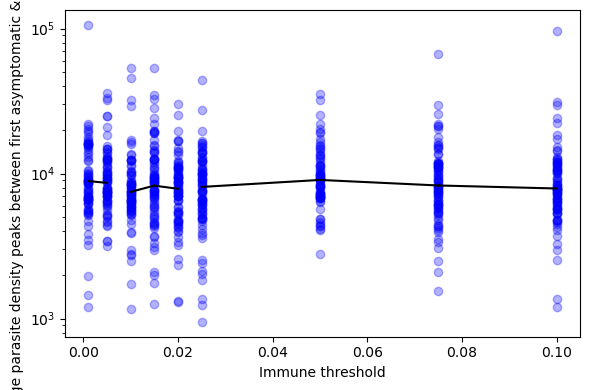

In [97]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, immunes,n_people,"Immune threshold",output,"immuneGone")

## Number of Alleles

In [98]:
nAlleles = [2,3,4,5,10,15,20,25,40,50,60,70,80,90,100,150,200,250]

In [99]:
outcomes = np.empty((len(outcomeLabels),n_people,len(nAlleles)))

for i,allele in enumerate(nAlleles):
    start = time.time()
    a = [allele,allele,allele,allele,allele]
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2.9693992137908936
3.310753107070923
3.565340995788574
3.805734872817993
4.547040224075317
5.095664024353027
5.388857126235962


/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


5.445478200912476
5.3199622631073
5.435177803039551
5.5494067668914795
5.590306043624878
5.729717969894409
5.8058178424835205
5.98363184928894
6.771457195281982
7.5795581340789795
8.33401608467102


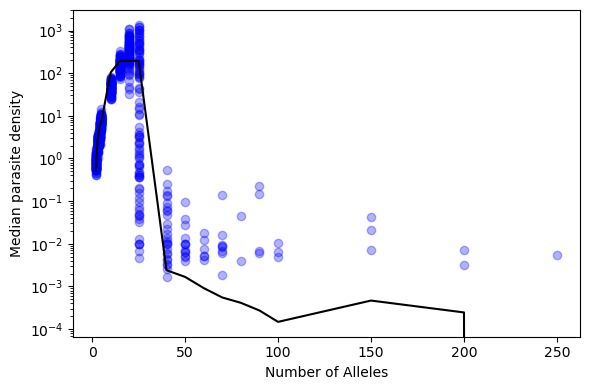

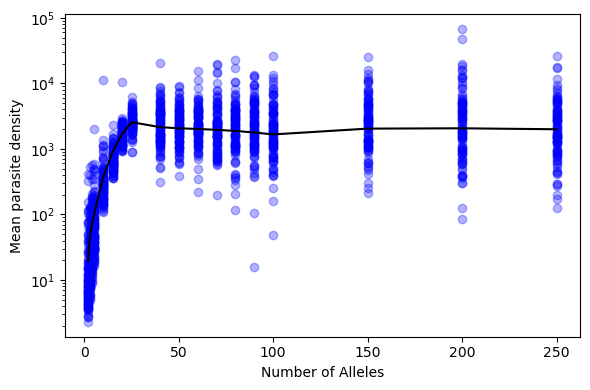

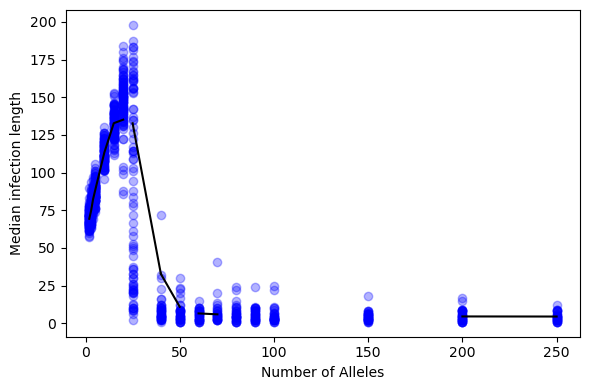

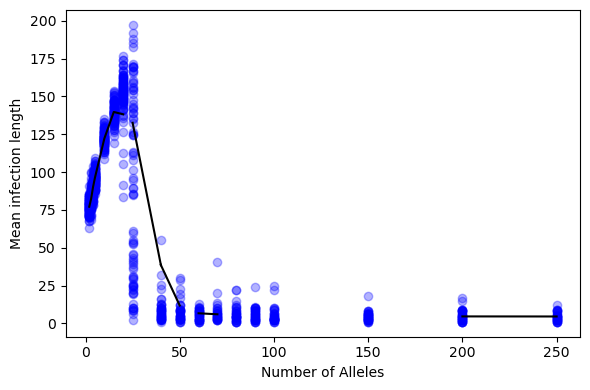

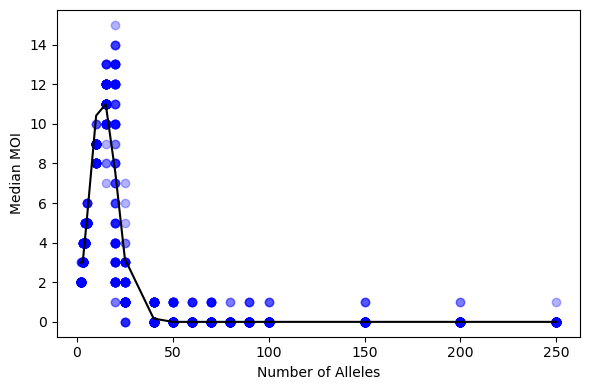

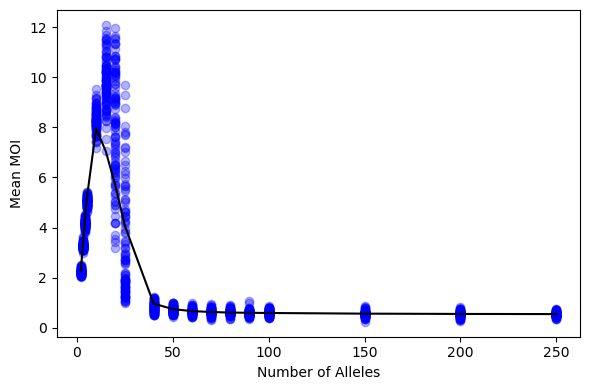

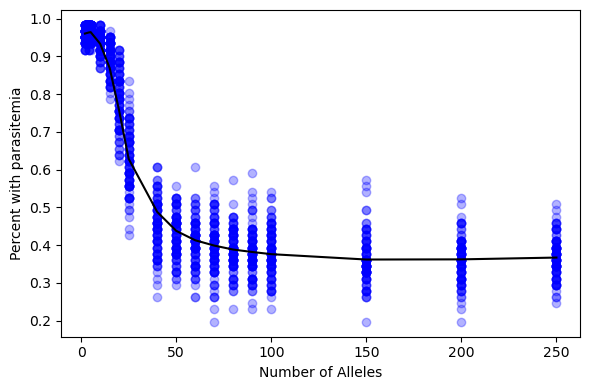

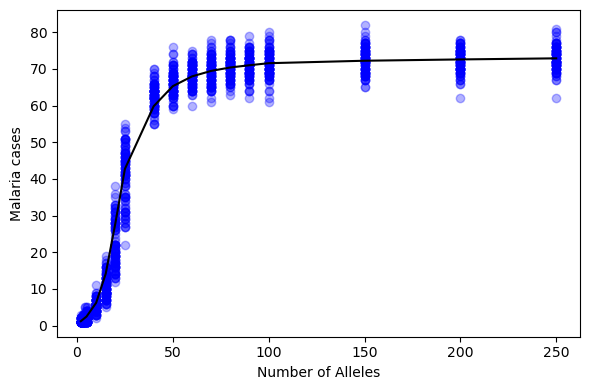

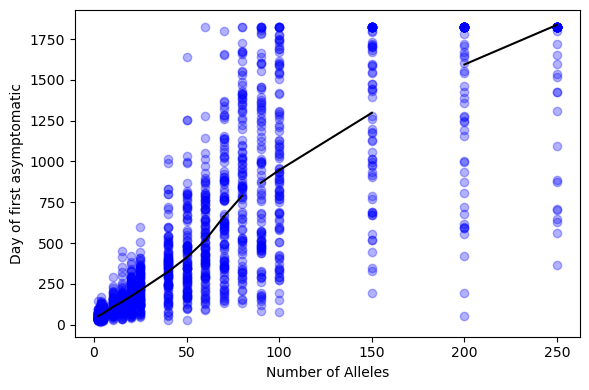

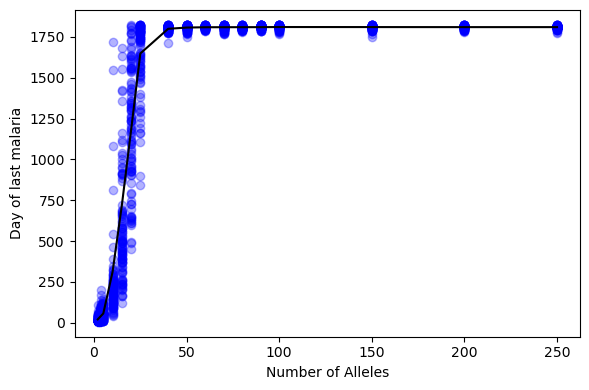

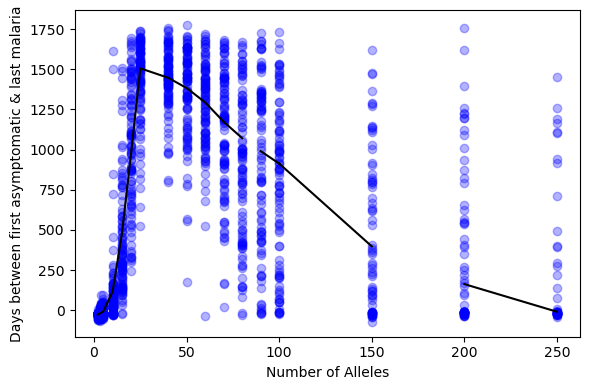

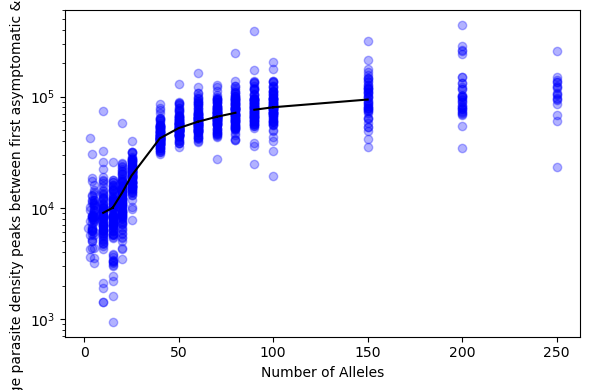

In [100]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, nAlleles,n_people,"Number of Alleles",output,"nAlleles")

## Allele frequency Skew

In [101]:
freqs = [0,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3]

In [104]:
outcomes = np.empty((len(outcomeLabels),n_people,len(freqs)))

for i,skew in enumerate(freqs):
    start = time.time()
    a = [10,10,10,10,10]
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,power=skew)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.65043306350708
4.599324941635132
4.572951078414917
4.608578681945801
4.482239007949829
4.439100980758667
4.436237096786499
4.338025093078613
4.292425870895386
4.2335100173950195
4.233371257781982


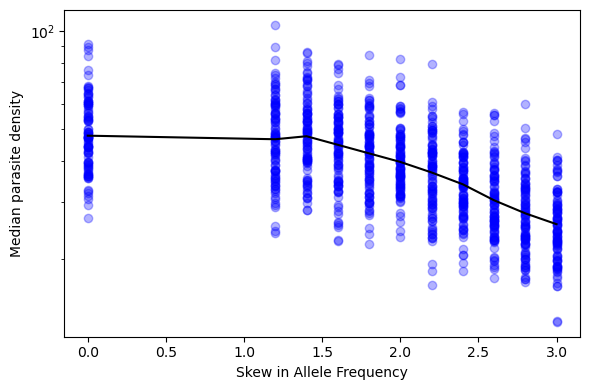

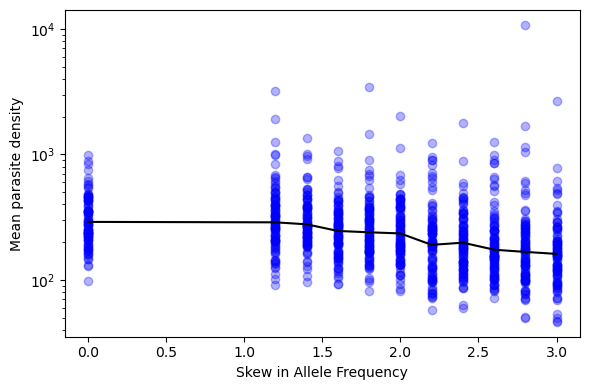

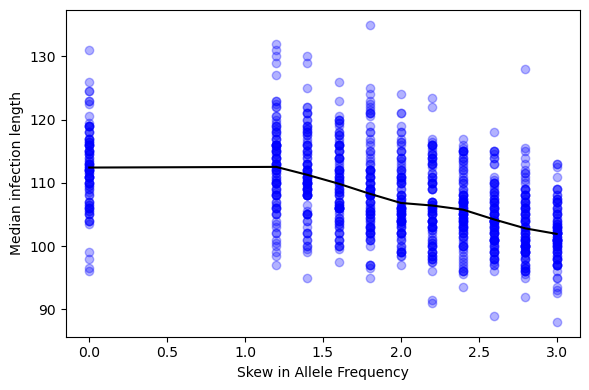

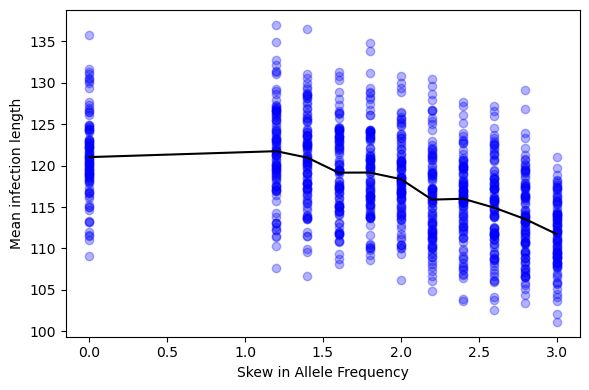

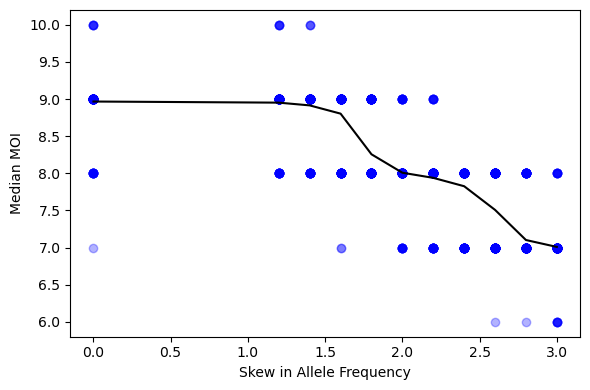

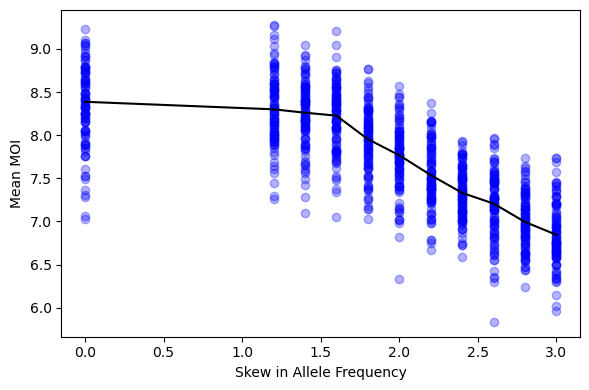

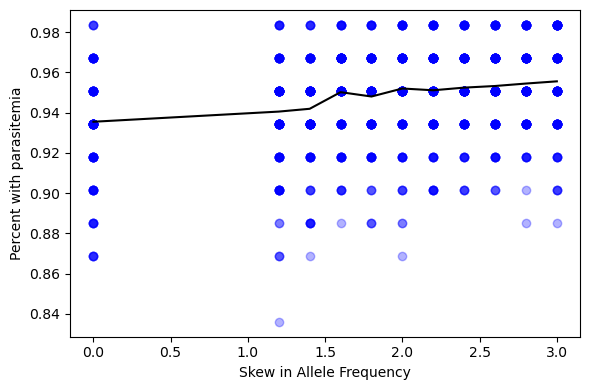

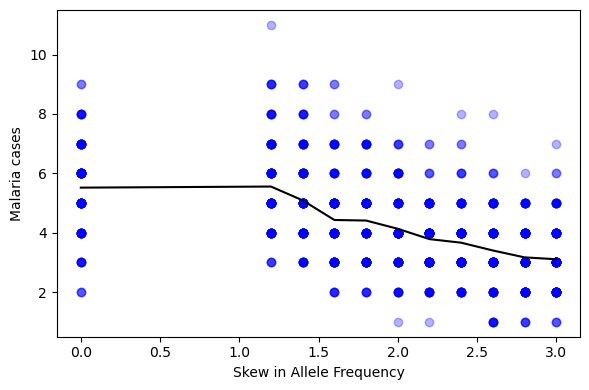

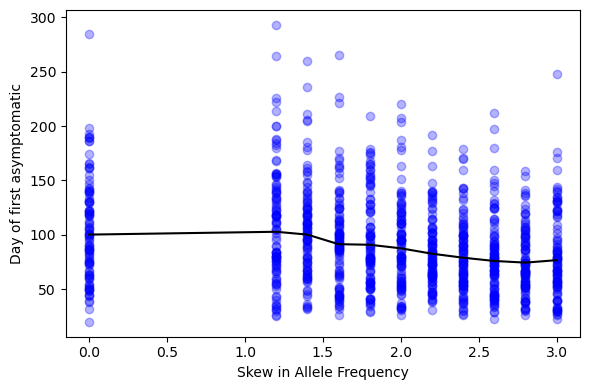

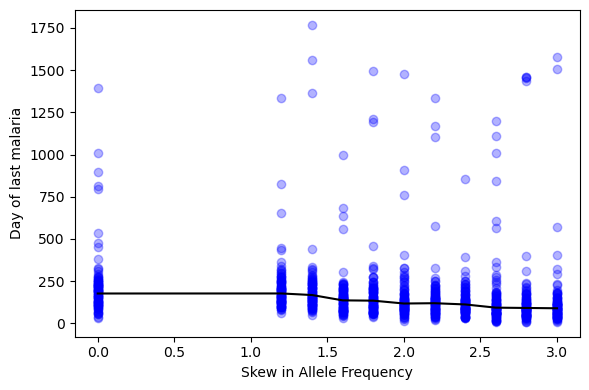

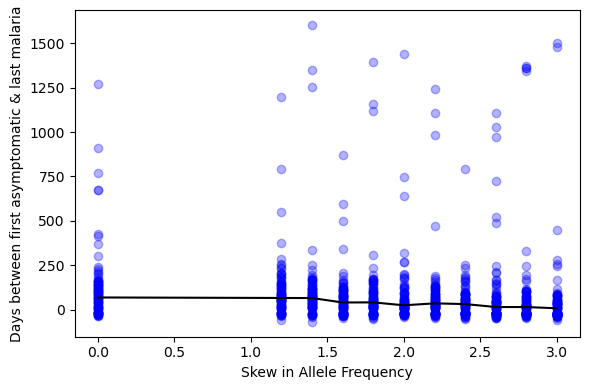

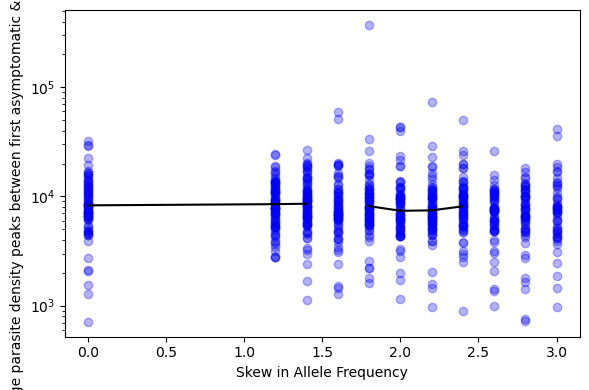

In [105]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, freqs,n_people,"Skew in Allele Frequency",output,"freqs")

## Transmission Intensity

In [106]:
eirs = [2,20,40,60,80,100,150,200,250]

In [107]:
outcomes = np.empty((len(outcomeLabels),n_people,len(eirs)))

for i,eir in enumerate(eirs):
    start = time.time()
    a = [10,10,10,10,10]
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr,eir=eir)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


1.8658630847930908
3.3948612213134766
4.582528829574585
5.499648094177246
6.199119806289673
6.887381076812744
8.217583894729614
9.286532878875732
10.34125804901123


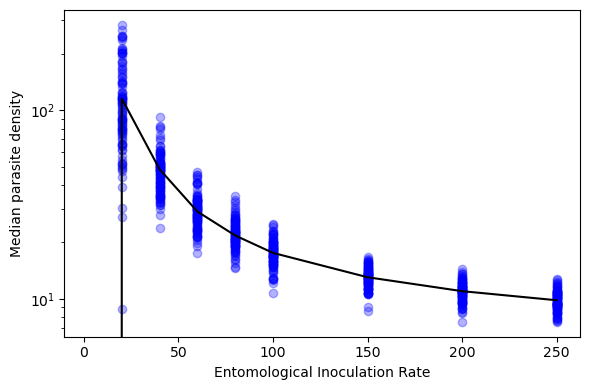

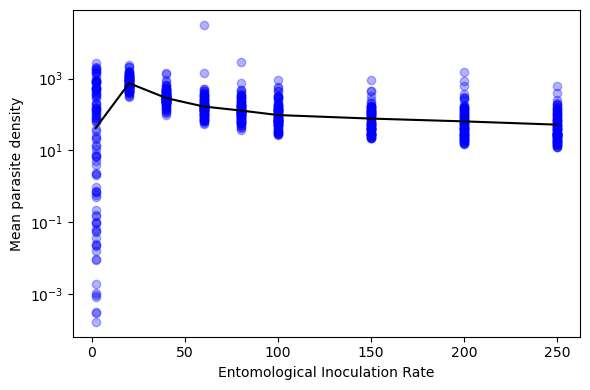

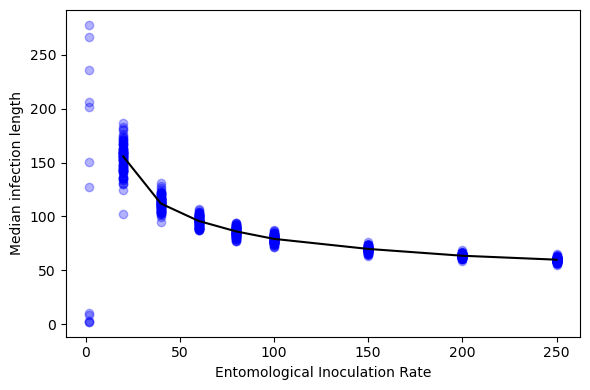

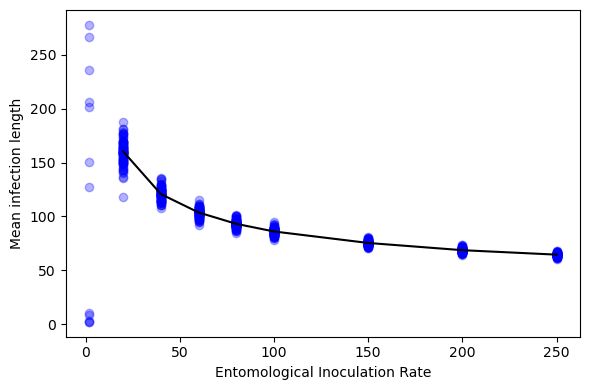

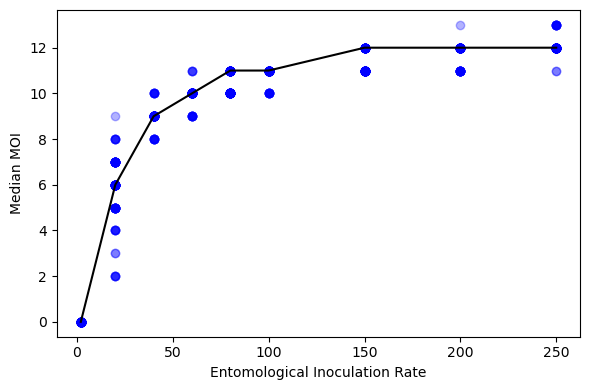

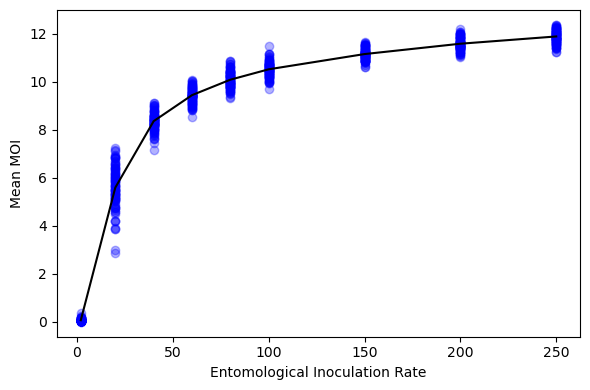

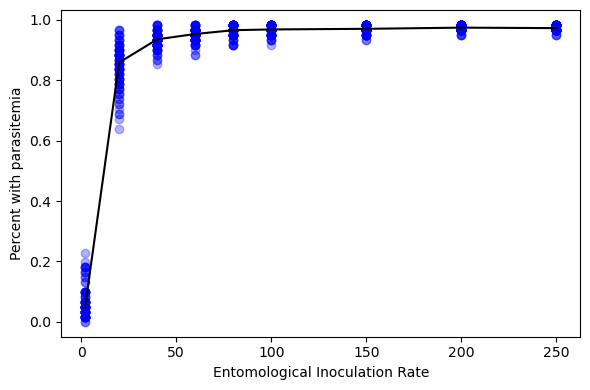

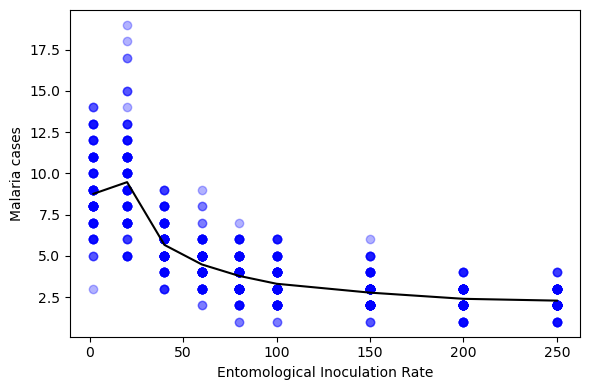

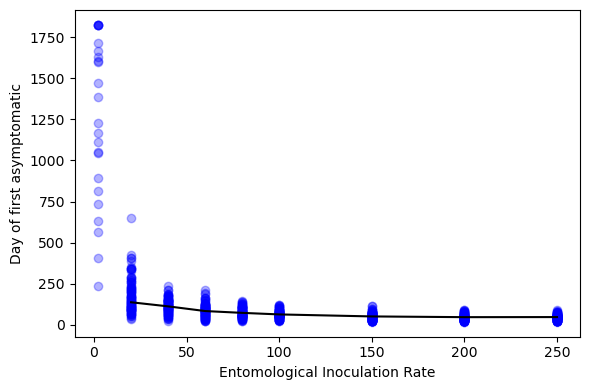

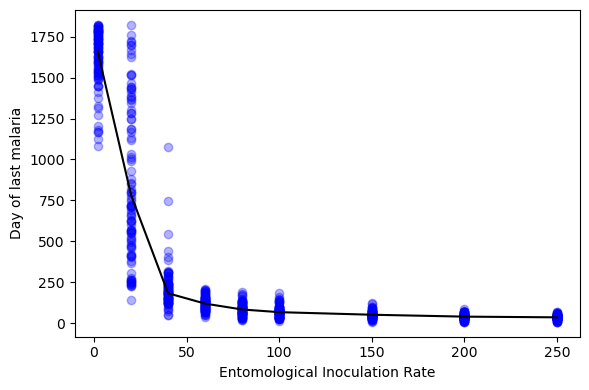

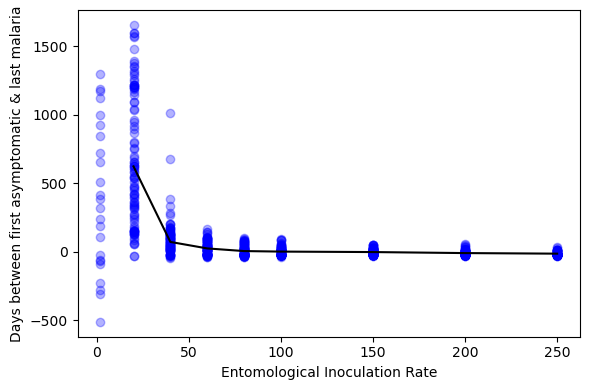

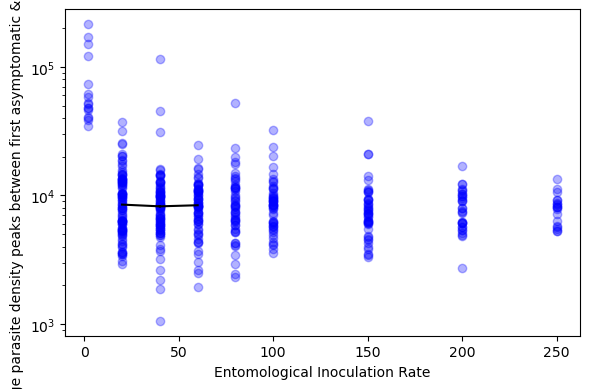

In [108]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, eirs,n_people,"Entomological Inoculation Rate",output,"eir")

## Weight

In [118]:
Locis = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,50,75,100]

In [119]:
outcomes = np.empty((len(outcomeLabels),n_people,len(Locis)))

for i,nLoci in enumerate(Locis):
    start = time.time()
    a = np.repeat(10,nLoci)
    w = np.repeat(1/nLoci,nLoci)
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infectmatrix = tent.simulate_person(y,a,w,fever_arr)
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,i] = np.median(Parasitemia)
        outcomes[1,person,i] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y,malaria)
        outcomes[2,person,i] = np.median(infectionlengths)
        outcomes[3,person,i] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,i] = np.median(MOI)
        outcomes[5,person,i] = np.mean(MOI)
        
        outcomes[6,person,i] = perPositivity
        outcomes[7,person,i] = len(malaria)
        
        pdensity = pmatrix[-1,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        if len(asymps):
            outcomes[8,person,i] = asymps[0]
            outcomes[10,person,i] = get_spacing(asymps, malaria)
            outcomes[11,person,i] = get_intermediate_density(peaks,asymps,malaria,pdensity)
        else:
            outcomes[8,person,i] = None
            outcomes[10,person,i] = None
            outcomes[11,person,i] = None
        outcomes[9,person,i] = malaria[-1]
        
    end = time.time()
    print(end-start)

4.283139944076538
4.417538166046143
4.531283855438232
4.61322808265686
4.641018867492676
4.705252170562744
4.9295642375946045
5.241065979003906
5.003766775131226
4.920980930328369
5.127397060394287
5.159840106964111
5.139547824859619
5.468583822250366
5.339808940887451
5.305762052536011
5.2622389793396
5.330931186676025
5.47315788269043
5.7444353103637695
6.318544149398804
7.0087339878082275
7.654839038848877


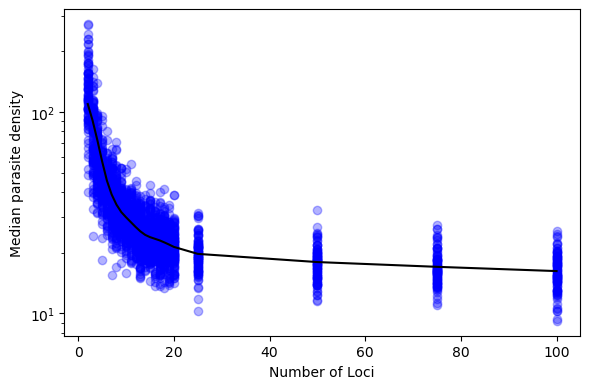

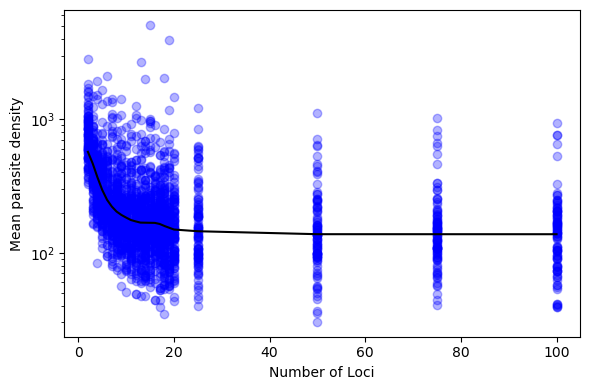

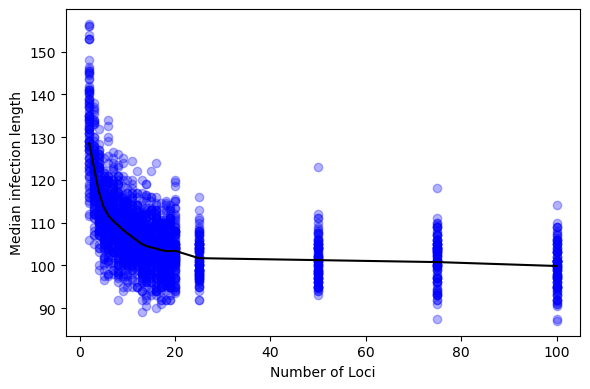

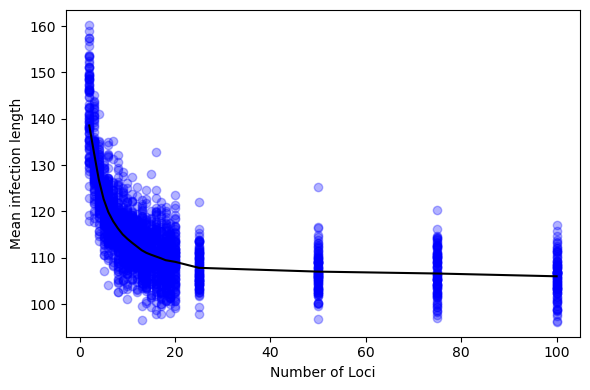

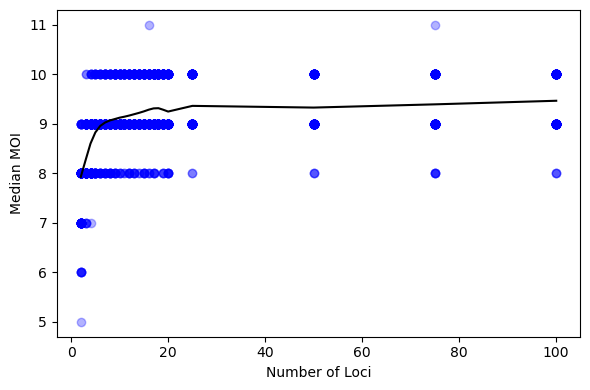

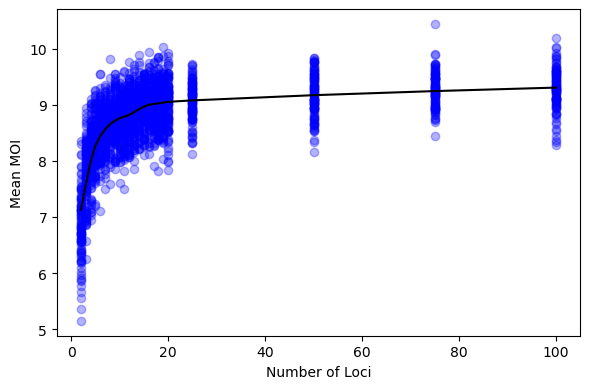

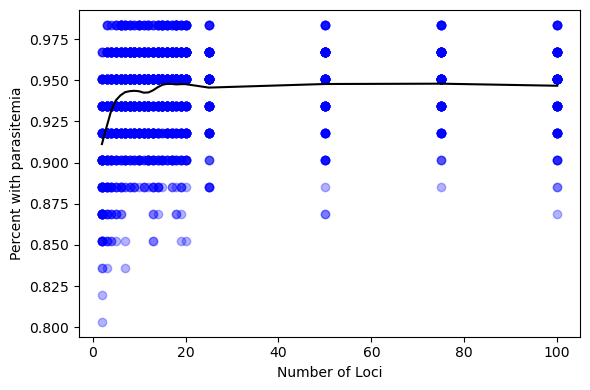

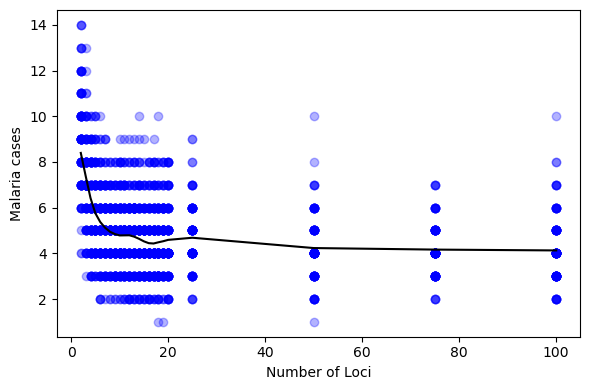

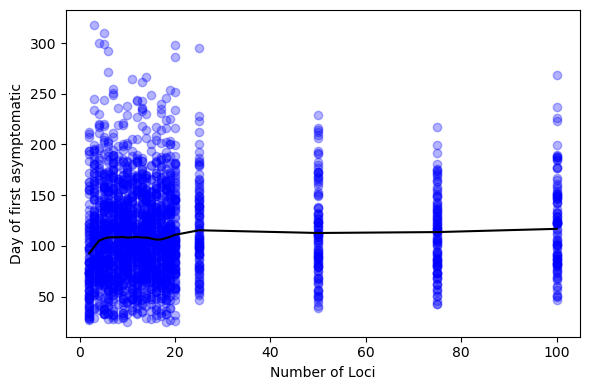

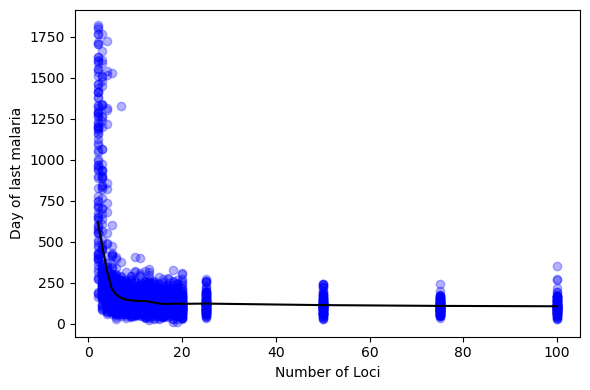

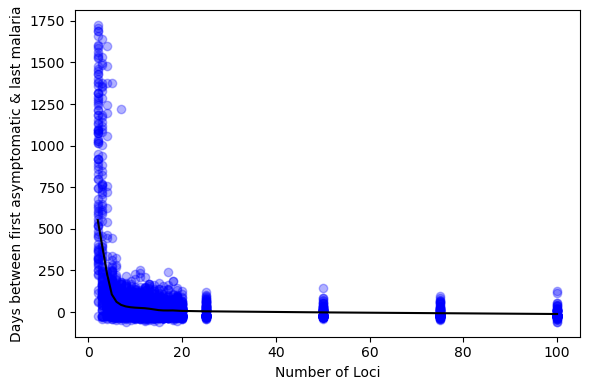

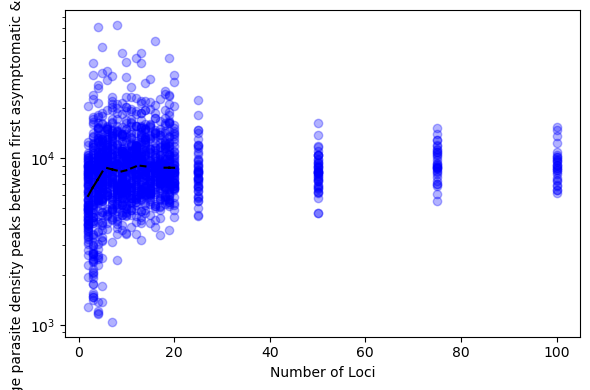

In [120]:
for row, lab, flag,output in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog,outputs):
    plot(outcomes[row,:,:], lab, flag, Locis,n_people,"Number of Loci",output,"nLoci")

## NEW ideas:

From above, I think I should include an allele frquency skew. Drop in immune threshold & turn down max pdensity. Let's see how how outcomes look when I do that.

Does not scale with transmission intensity welll. Can only achieve "malaria case" parasitemias if have multiple infections at the same time...
If higher transmission intensity, can never get breakthrough malaria cases.
WHAT actually is a reasonable number of allleles????

Pdensity is consistently to high --> Do I change how immunity is impacted?

Parasite density
min:-3.000000000000003
max:4.558802699892454
median:1.4032988748759385
mean:1.3090417292389331
std:1.1397423256100485
---------------------
Infection length
min:1
max:470
median:65.0
mean:93.66650615670359
std:81.11264731705374
---------------------
MOI
min:0
max:14
median:5.0
mean:4.53027027027027
std:2.355534582679105
---------------------
% Parasitemia
min:0.7837837837837838
max:0.972972972972973
median:0.918918918918919
mean:0.9245945945945947
std:0.03770149179494952
---------------------
Malaria cases per year
min:0.125
max:0.75
median:0.375
mean:0.375
std:0.13806701271484076
---------------------


NameError: name 'all_immunity' is not defined

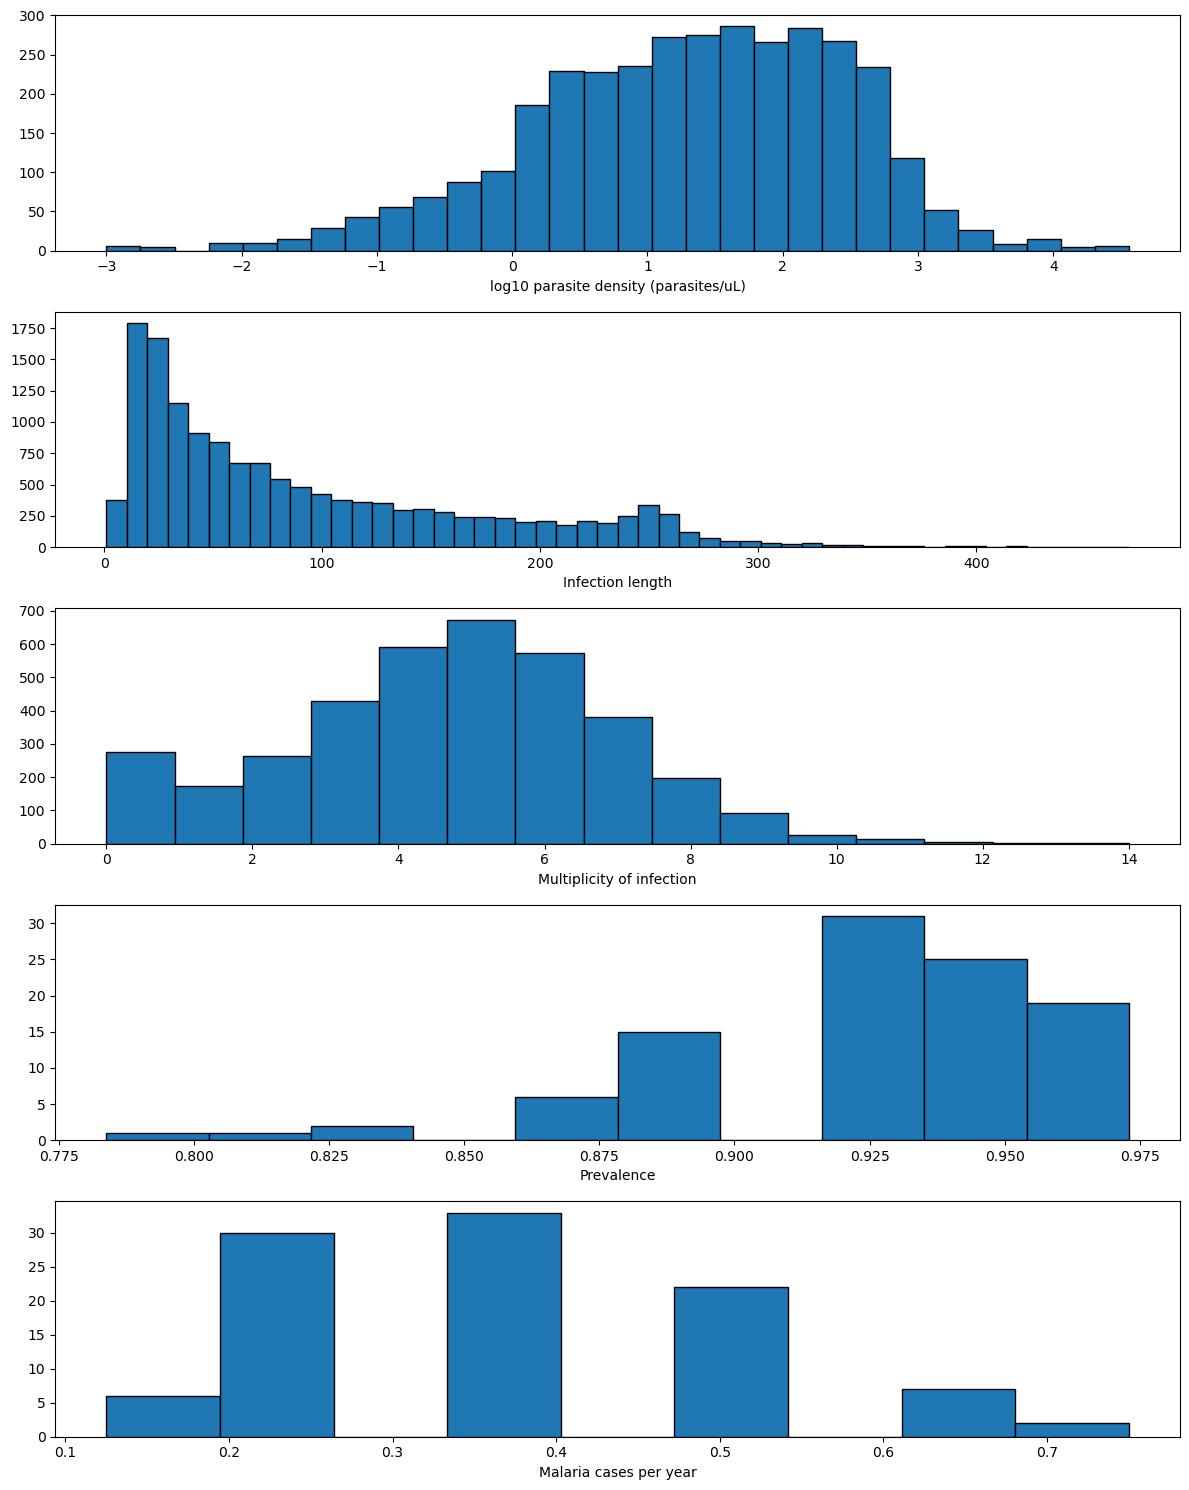

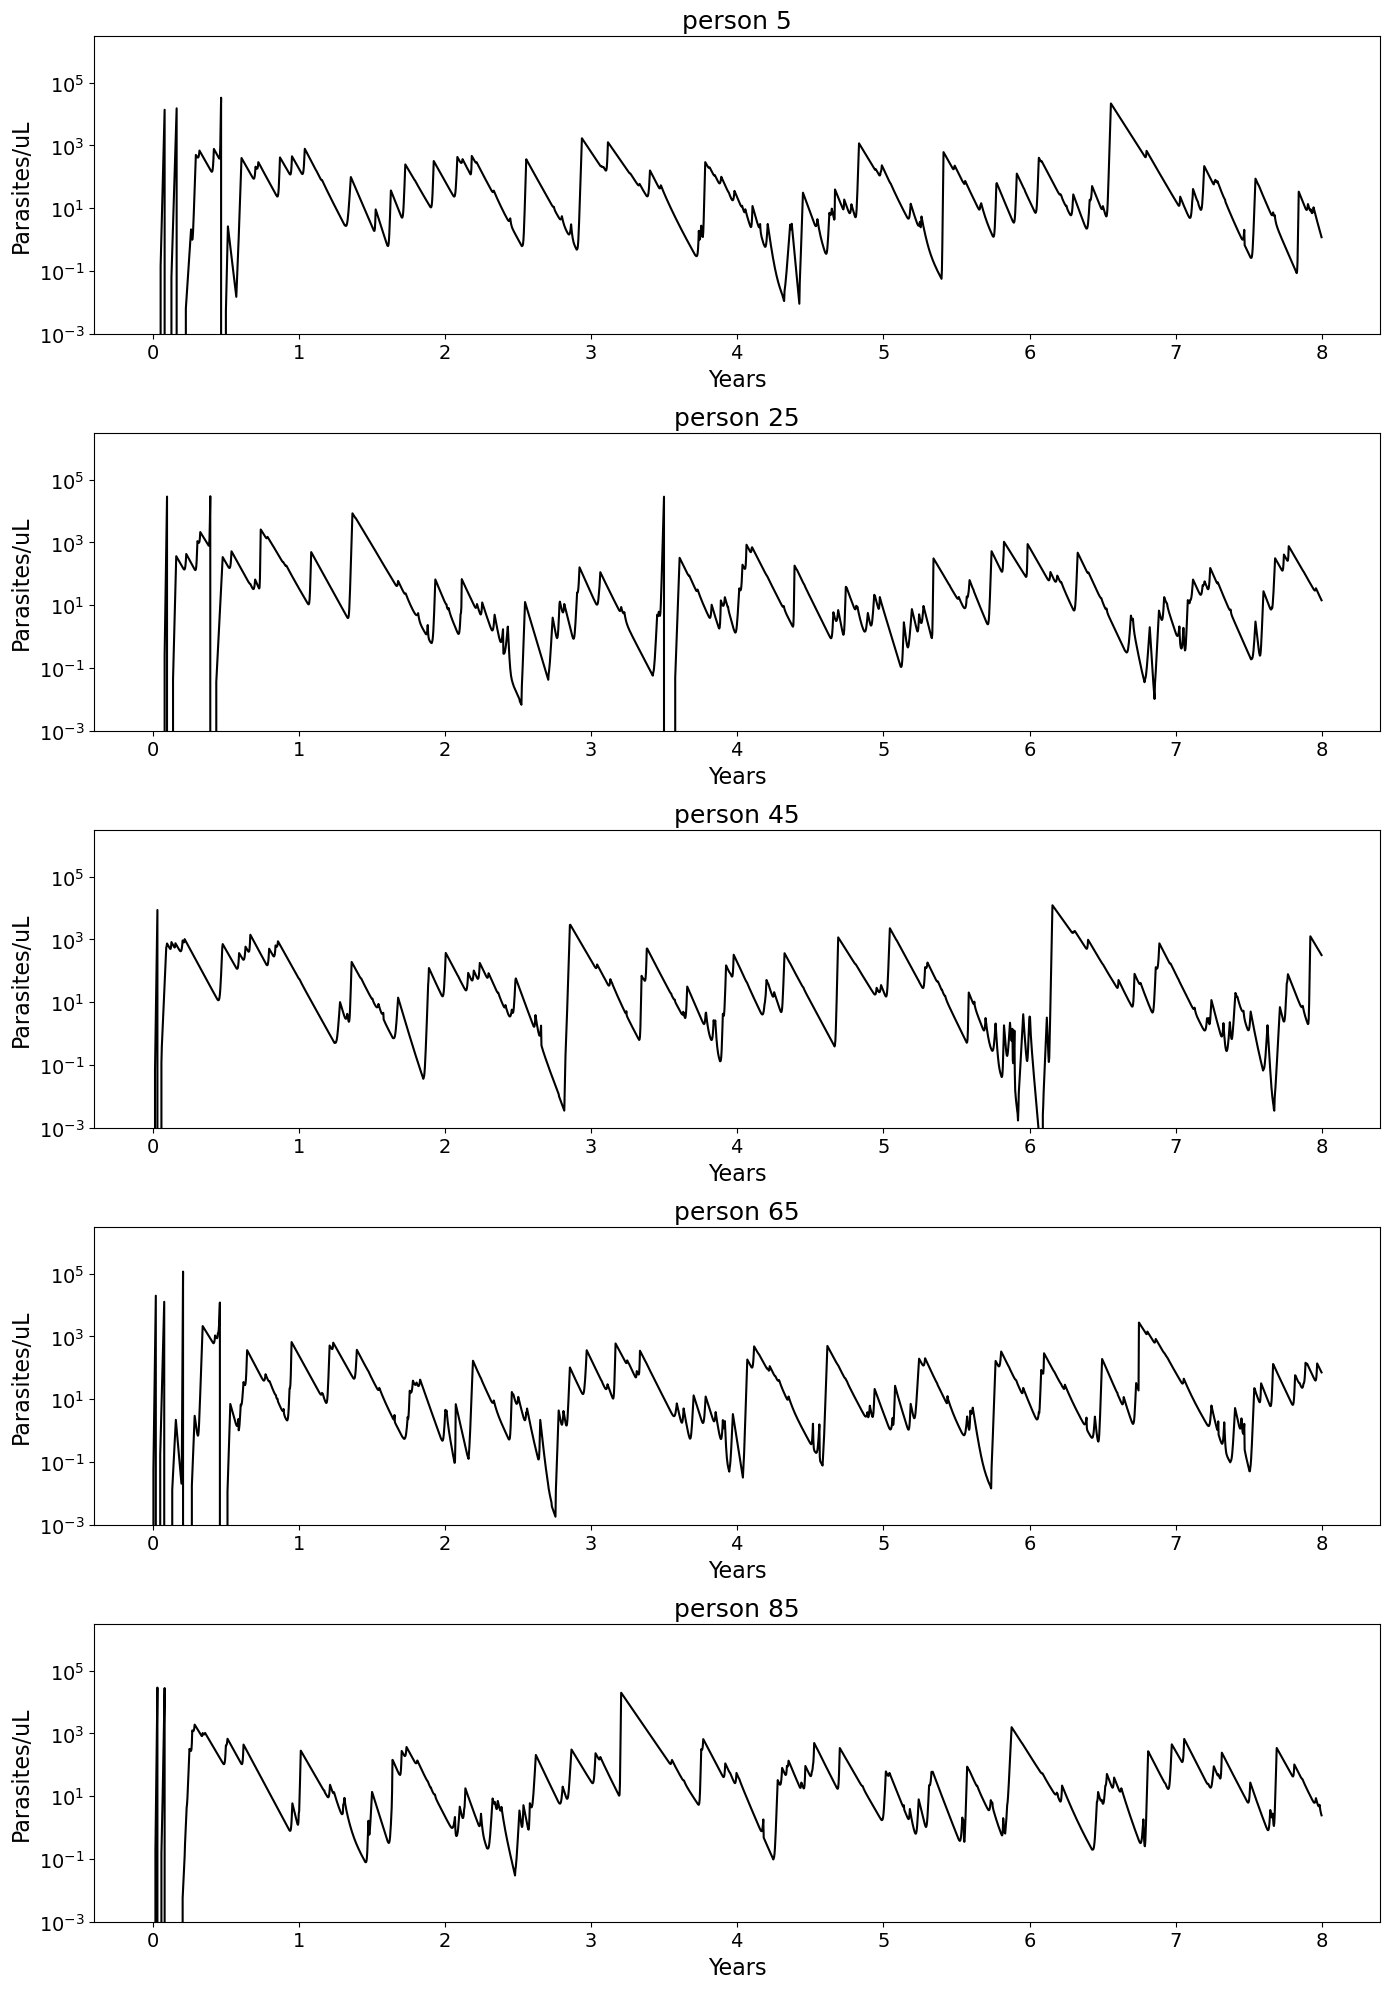

In [109]:
y=8
a = np.repeat(10,2)
w = [1/2,1/2]
eir=40
n_people = 100
all_parasites, all_immunity, all_strains, all_malaria, all_infections = tent.simulate_cohort(n_people,y,a,w,eir=eir,power=3,immune_thresh=0.001, maxParasitemia=5.2, xh=0.8,b=-2,t12=500)
tp.check_outcomes(a,5,all_parasites,all_strains,all_malaria)

Parasite density
min:-1.983761234020358
max:6.002964090834105
median:1.7233163361512203
mean:1.7479078409392679
std:0.928351972230361
---------------------
Infection length
min:1
max:361
median:89.0
mean:99.82622493018533
std:60.47116360350188
---------------------
MOI
min:0
max:19
median:9.0
mean:8.075675675675676
std:4.543329259439448
---------------------
% Parasitemia
min:0.7297297297297297
max:0.972972972972973
median:0.8918918918918919
mean:0.8924324324324324
std:0.04169176259086197
---------------------
Malaria cases per year
min:0.6
max:2.0
median:1.0
mean:1.126
std:0.3245365926979576
---------------------


NameError: name 'all_immunity' is not defined

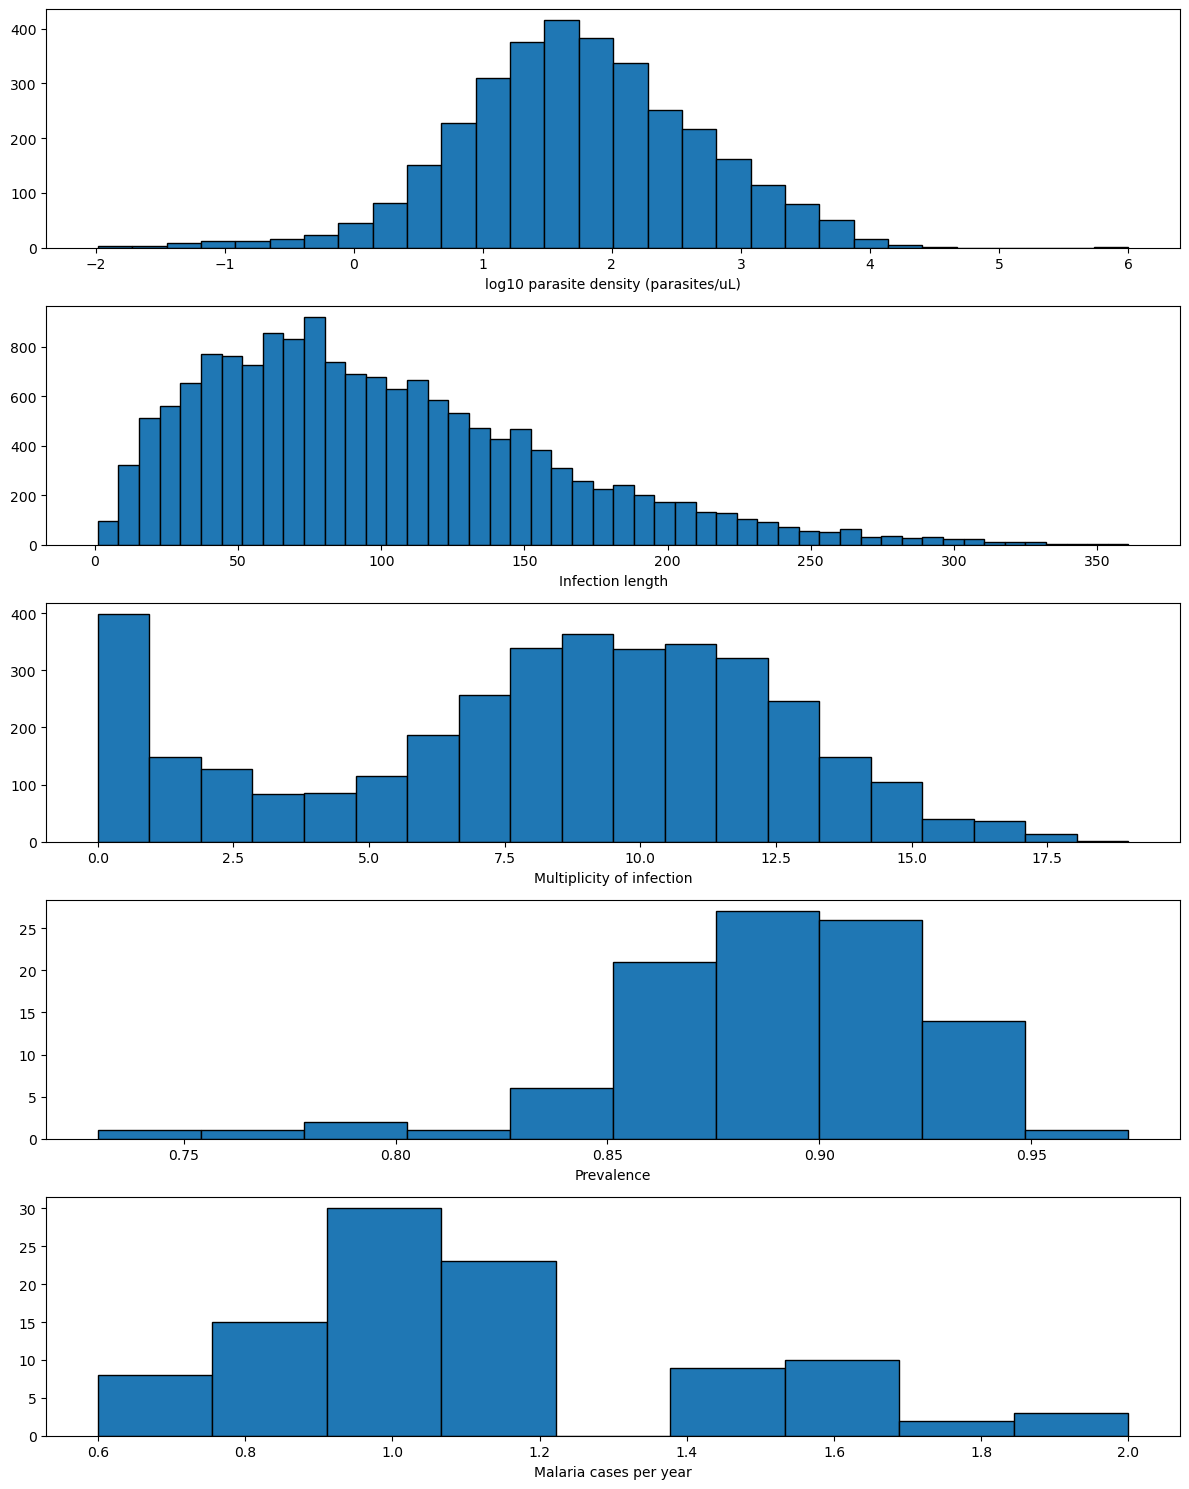

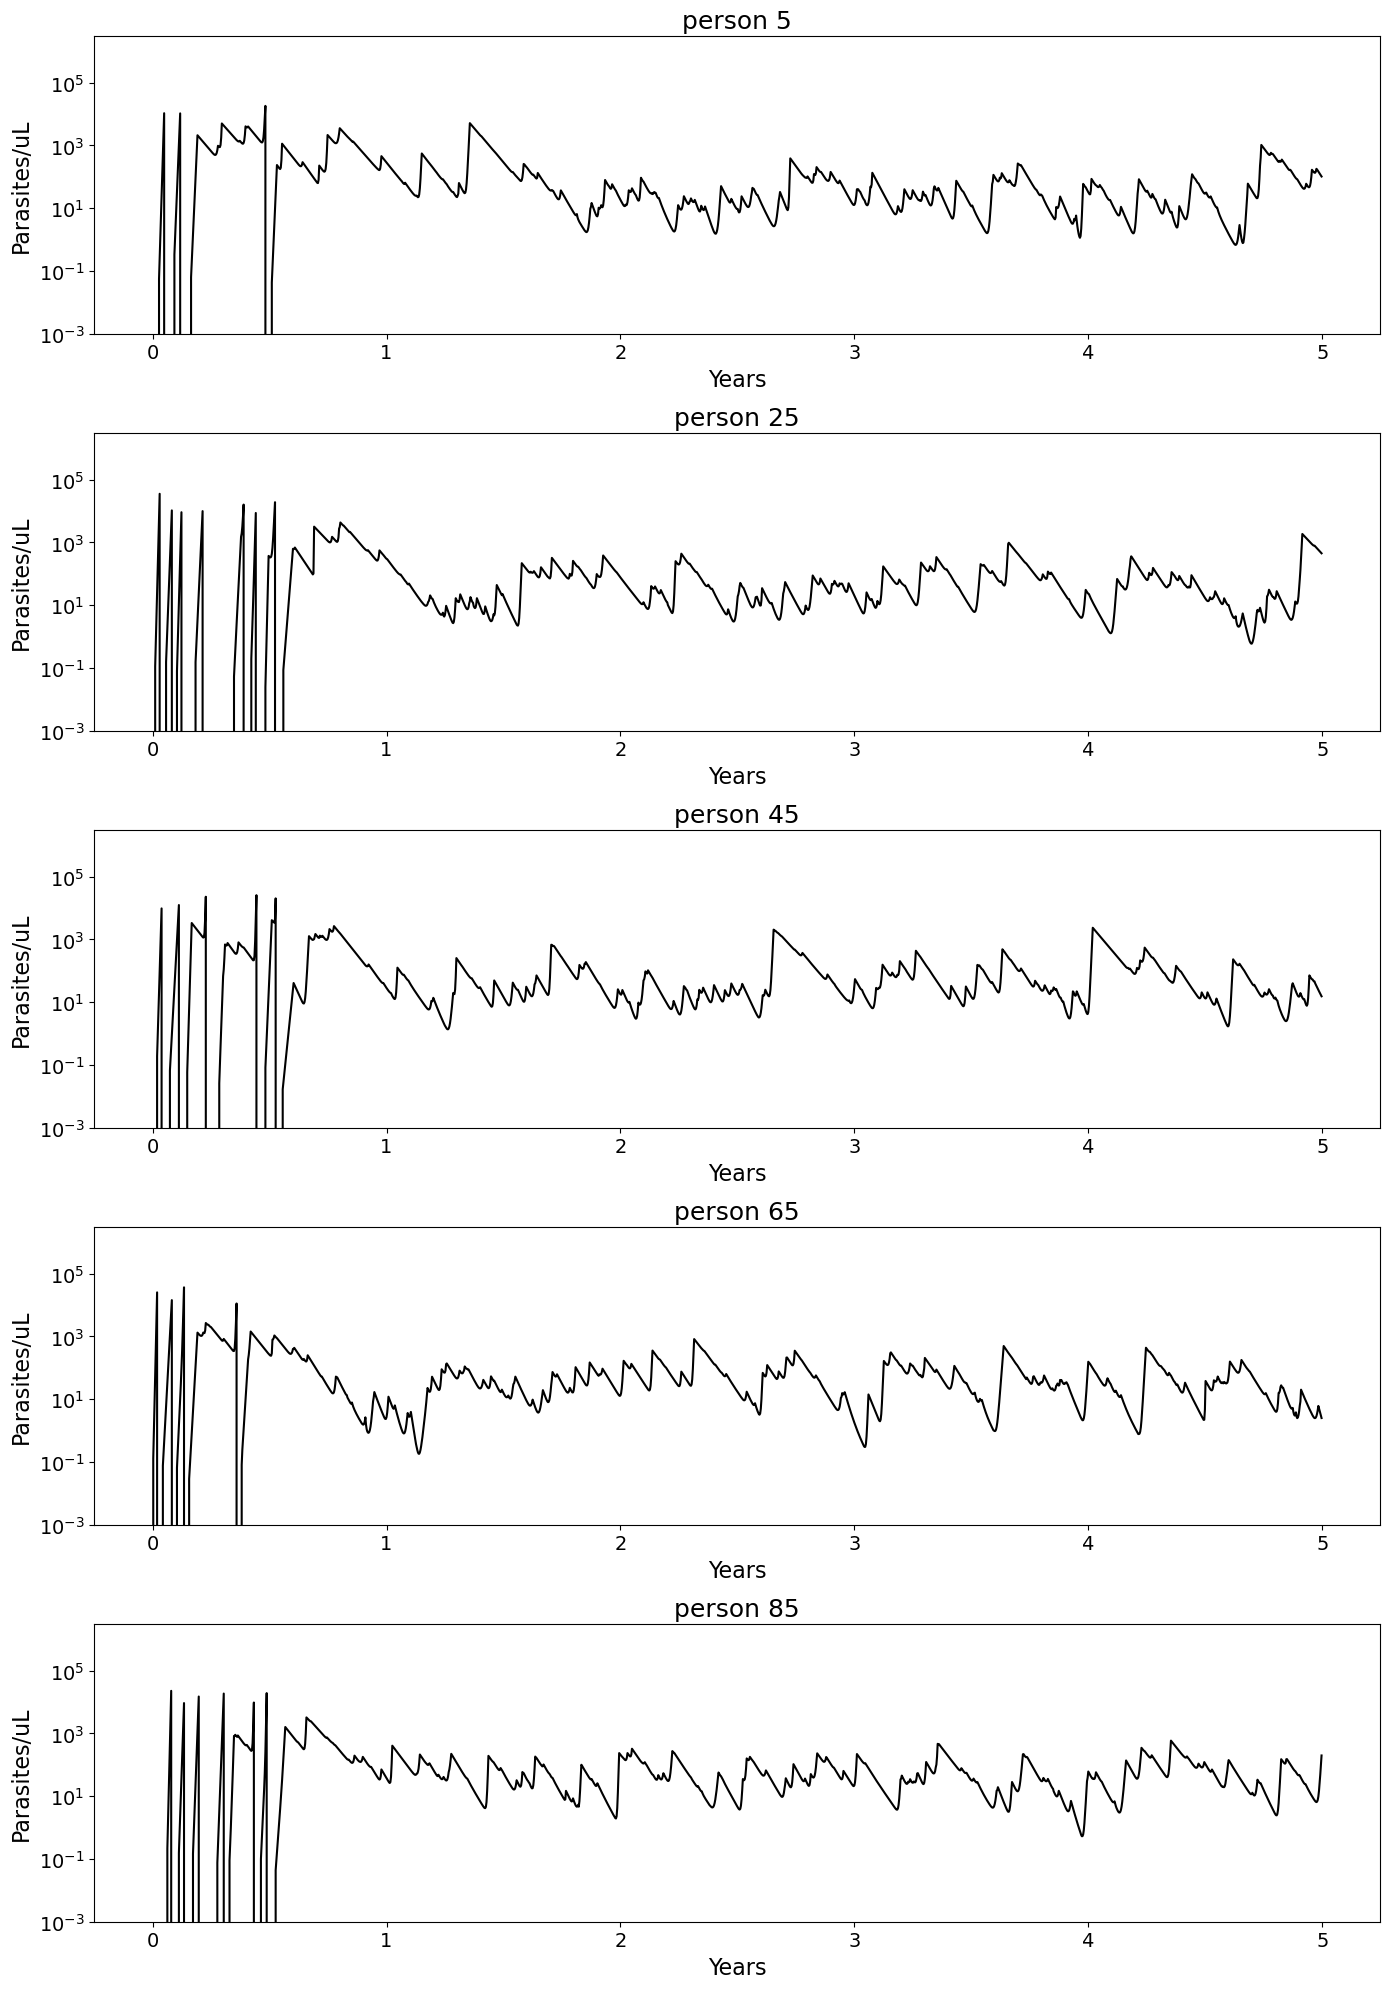

In [17]:
y=5
a = [10,10,10,10,10]
w = [1/5,1/5,1/5,1/5,1/5]
eir=40
n_people = 100
all_parasites, all_immunity, all_strains, all_malaria, all_infections = tent.simulate_cohort(n_people,y,a,w)
tp.check_outcomes(a,5,all_parasites,all_strains,all_malaria)